In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from lmfit import Model

import os
spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath("./../plots") + "/"

import sys
module_path = os.path.abspath("./../../module")
sys.path.append(module_path)
import redh3p as rhp
import importlib
importlib.reload(rhp)

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter("ignore", category=AstropyWarning)
warnings.simplefilter('ignore', np.RankWarning)

##################

# order 36
fits_path_36 = spec_dir+'order36/jun02s*'
header_path = spec_dir+'jun02s*'

order36_data = rhp.read_fits(path=fits_path_36)[:,:,:1000]

int0 = 22
flat_range = range(32,41+1)
dark_range = range(22,31+1)

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat_range[0], stop=flat_range[-1], init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark_range[0], stop=dark_range[-1], init=int0)

spec36_reducelist = []

sky_frame = [51,59,60,72,78,79,91,103]

spec_range = range(60,103+1)

for fn in range(spec_range[0], spec_range[-1]):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        
        reduce_spec36 = (order36_data[fn-int0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        # reduce_spec36[reduce_spec36<0] = 0
        
        spec36_reducelist.append(reduce_spec36)
        
spec36_reduced = np.array(spec36_reducelist)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

R36 = 73194.84858495607
R32 = 72803.45487481622
R = np.mean((R36,R32))

star_fr = range(104,112)
# star_fr = range(43, 51)

modeA36 = np.sum((order36_data[star_fr[0]-int0], 
                  order36_data[star_fr[3]-int0], 
                  order36_data[star_fr[4]-int0], 
                  order36_data[star_fr[7]-int0]), axis=0)

modeB36 = np.sum((order36_data[star_fr[1]-int0], 
                  order36_data[star_fr[2]-int0], 
                  order36_data[star_fr[5]-int0], 
                  order36_data[star_fr[6]-int0]), axis=0)

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star



flux36_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.003, min=0, max=0.01)
flux36_params.add('a1', value=36)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))

spat_ax36 = np.linspace(0, modeAB36.shape[0]-1, modeAB36.shape[0])

for i in range(len(modeAB36.T)):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_ax36)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
        
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10 # alpha Lyrae in atmospheric window 2.2 mu m
m_lambda = 6.749 # Kmag HD 131885
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))

star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm

Fc36 = Fbb36/Fobs36

width36 = spec36_reduced.shape[1]
length36 = spec36_reduced.shape[2]

spat_scale36 = 0.288
spec_scale36 = 2.908e-5

slit_area36 = spat_scale36 * width36 * spec_scale36 * length36

exp_spec = 60

fjc36_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    
fjc36 = np.array(fjc36_list)

# rescale spatial axis
RA_modeA = 224.23866
RA_modeB = 224.24037
DEC_modeA = -26.28654
DEC_modeB = -26.28358

arcsec_diff_star = np.sqrt(((RA_modeA-RA_modeB)*3600)**2 + ((DEC_modeA-DEC_modeB)*3600)**2)
arcsec_per_pix_new = 0.1

star36_mean = np.mean((modeAB36.T[200:1800,20:200]), axis=0)

pix_diff_star36 = np.where(star36_mean==np.min(star36_mean))[0][0] - np.where(star36_mean==np.max(star36_mean))[0][0]

# pix_diff_star36 = np.where(modeAB36.T[200]==np.min(modeAB36.T[200]))[0][0] -\
#     np.where(modeAB36.T[200]==np.max(modeAB36.T[200]))[0][0]

zoom_fac36 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star36

fjc36_rs = scipy.ndimage.zoom(fjc36, [1,zoom_fac36,1], mode='nearest')

# order 32
fits_path_32 = spec_dir+'order32/jun02s*'

order32_data = rhp.read_fits(path=fits_path_32)

avg_flat_order32 = rhp.calc_avg(data=order32_data, start=flat_range[0], stop=flat_range[-1], init=int0)
avg_dark_order32 = rhp.calc_avg(data=order32_data, start=dark_range[0], stop=dark_range[-1], init=int0)

spec32_reducelist = []

for fn in range(spec_range[0], spec_range[-1]):
    if fn in sky_frame:
        continue
    else:
        skyframe32 = rhp.scale_sky_frame(data=order32_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        # skyframe32 = rhp.single_sky_frame(data=order32_data, datfn=fn, skyfn=sky_frame, init=int0)
        
        reduce_spec32 = (order32_data[fn-int0] - skyframe32) / (avg_flat_order32 - avg_dark_order32)
        # reduce_spec32[reduce_spec32<0] = 0
        
        spec32_reducelist.append(reduce_spec32)
        
spec32_reduced = np.array(spec32_reducelist)

waverange32 = fits.open(spec_dir + 'order32/' + 'waverange.fits', ignore_missing_end=True)[0].data

modeA32 = np.sum((order32_data[star_fr[0]-int0], 
                  order32_data[star_fr[3]-int0], 
                  order32_data[star_fr[4]-int0], 
                  order32_data[star_fr[7]-int0]), axis=0)

modeB32 = np.sum((order32_data[star_fr[1]-int0], 
                  order32_data[star_fr[2]-int0], 
                  order32_data[star_fr[5]-int0], 
                  order32_data[star_fr[6]-int0]), axis=0)

modeAB32 = ((modeA32 - modeB32)/4)/(avg_flat_order32 - avg_dark_order32)/exp_star

flux32_model = Model(rhp.gaussian_fit)

flux32_params = flux32_model.make_params()
flux32_params.add('a0', value=0.003, min=0, max=0.01)
flux32_params.add('a1', value=42)
flux32_params.add('a2', value=2, min=0.5, max=5)
flux32_params.add('a3', value=0)
flux32_params.add('a4', value=0)
flux32_params.add('a5', value=0)

star32_a0 = np.zeros(np.size(modeAB32,1))
star32_a2 = np.zeros(np.size(modeAB32,1))

spat_ax32 = np.linspace(0, modeAB32.shape[0]-1, modeAB32.shape[0])

for i in range(len(modeAB32.T)):
    try:
        flux32_fit_result = flux32_model.fit(modeAB32.T[i], flux32_params, x=spat_ax32)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order32')
        
    star32_a0[i] = flux32_fit_result.params['a0'].value
    star32_a2[i] = flux32_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10 # alpha Lyrae in atmospheric window 2.2 mu m
m_lambda = 6.749 # Kmag HD 131885
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb32 = F_a0 * ((lambda_aw/waverange32)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange32*T)) - 1))

star32_fwhm = star32_a2*(np.sqrt(2*np.log(2))*2)
Fobs32 = star32_a0 * star32_fwhm

Fc32 = Fbb32/Fobs32

width32 = spec32_reduced.shape[1]
length32 = spec32_reduced.shape[2]

spat_scale32 = 0.288
spec_scale32 = 3.304e-5

slit_area32 = spat_scale32 * width32 * spec_scale32 * length32

fjc32_list = []

for i in range(np.size(spec32_reduced, axis=0)):
    fjc32_list.append(spec32_reduced[i] / exp_spec * Fc32 * 4.2535e10 / slit_area32)
    
fjc32 = np.array(fjc32_list)

arcsec_diff_star = np.sqrt(((RA_modeA-RA_modeB)*3600)**2 + ((DEC_modeA-DEC_modeB)*3600)**2)
arcsec_per_pix_new = 0.1

star32_mean = np.mean((modeAB32.T[200:1800,20:200]), axis=0)

pix_diff_star32 = np.where(star32_mean==np.min(star32_mean))[0][0] - np.where(star32_mean==np.max(star32_mean))[0][0]

# pix_diff_star32 = np.where(modeAB32.T[200]==np.min(modeAB32.T[200]))[0][0] -\
#     np.where(modeAB32.T[200]==np.max(modeAB32.T[200]))[0][0]

zoom_fac32 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star32

fjc32_rs = scipy.ndimage.zoom(fjc32, [1,zoom_fac32,1], mode='nearest')

# fjc36_rs = np.delete(fjc36_rs, np.s_[260:], 1)
# fjc32_rs = np.concatenate((fjc32_rs, np.zeros((38,1,fjc32_rs.shape[2]))), axis=1)

# fjc36_rs[:,24:50,81:90] = fjc36_rs[:,24:50,71:80]

In [42]:
star_spec_to_fit = modeAB32[20:60,:1000]

flux32_model = Model(rhp.gaussian_fit)

flux32_params = flux32_model.make_params()
flux32_params.add('a0', value=0.003)
flux32_params.add('a1', value=22)
flux32_params.add('a2', value=2)
flux32_params.add('a3', value=0)
flux32_params.add('a4', value=0)
flux32_params.add('a5', value=0)

star32_a0 = np.zeros(star_spec_to_fit.shape[1])
star32_a2 = np.zeros(star_spec_to_fit.shape[1])

# spat_ax32 = np.linspace(0, modeAB32.shape[0]-1, star_spec_to_fit.shape[0])
spat_ax32 = np.arange(star_spec_to_fit.shape[0])

for i in range(len(star_spec_to_fit.T)):
# for i in range(700,800):
    flux32_fit_result = flux32_model.fit(star_spec_to_fit.T[i], flux32_params, x=spat_ax32)
    # plt.figure()
    # plt.title('i='+str(i))
    # plt.plot(spat_ax32, star_spec_to_fit.T[i])
    # plt.plot(spat_ax32, flux32_fit_result.best_fit, 'r-', label='best fit')
        
    star32_a0[i] = flux32_fit_result.params['a0'].value
    star32_a2[i] = flux32_fit_result.params['a2'].value

In [45]:
Fobs32.shape

(1024,)

(730.0, 750.0)

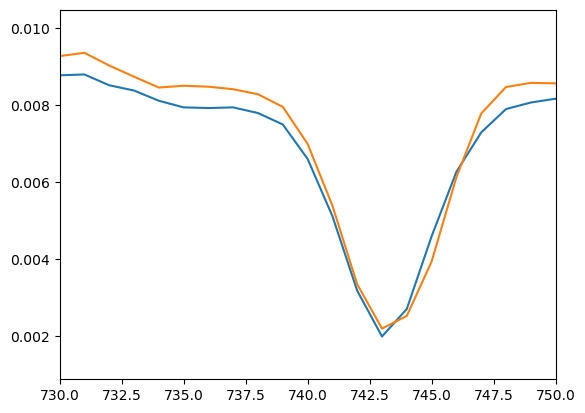

In [60]:
plt.plot(star32_a0 * star32_a2*(np.sqrt(2*np.log(2))*2))
plt.plot(Fobs32[:1000])
plt.xlim(730,750)

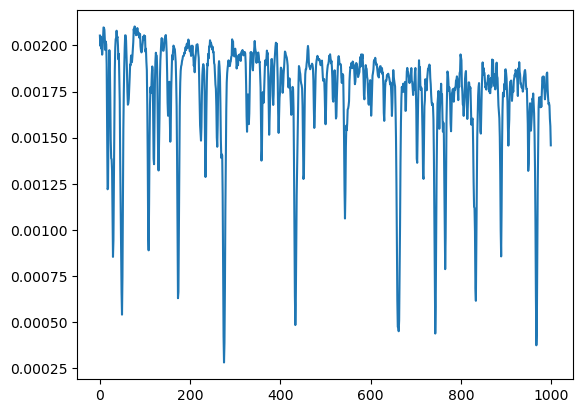

In [43]:
plt.plot(star32_a0)

In [7]:
modeAB32.shape

(166, 1024)

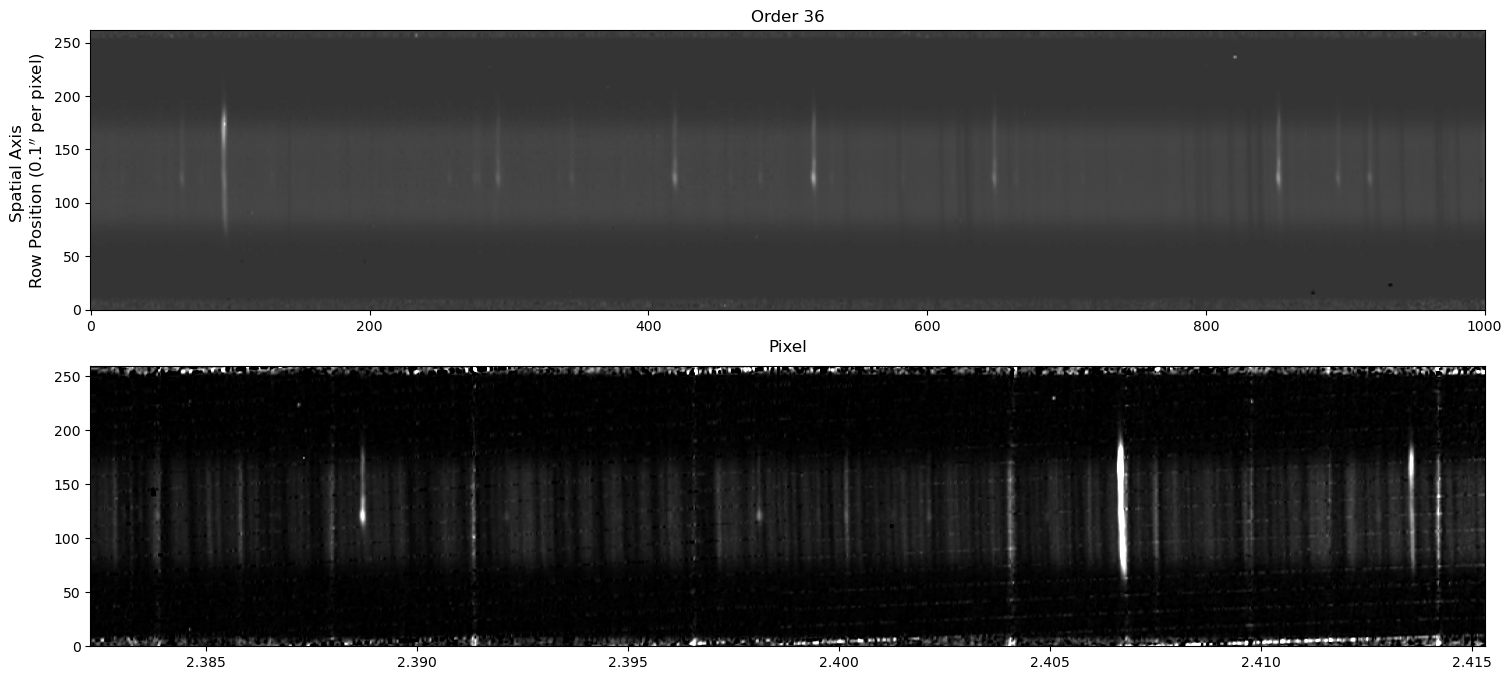

In [2]:
spec36_h2 = np.concatenate((fjc36_rs[:,:262,:101],fjc36_rs[:,:262,189:201], fjc36_rs[:,:262,113:1001]), axis=2)
wave36_h2 = waverange36[:1001]

spec32_h2 = fjc32_rs[:,:,:1001]
wave32_h2 = waverange32[:1001]


fig, (ax1, ax2) = plt.subplots(2, 1 , figsize=(18,8))

ax1.imshow(spec36_h2[0],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1), 
           origin='lower')
ax1.set_ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
ax1.set_xlabel('Pixel', fontsize=12)
ax1.set_title('Order 36', fontsize=12)

ax2.imshow(spec32_h2[0],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.002), 
           origin='lower', extent=[wave32_h2[0], wave32_h2[-1], 0, spec32_h2[0].shape[0]])
# plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
# plt.xlabel('Pixel', fontsize=12)
# plt.title('Order 32', fontsize=12)

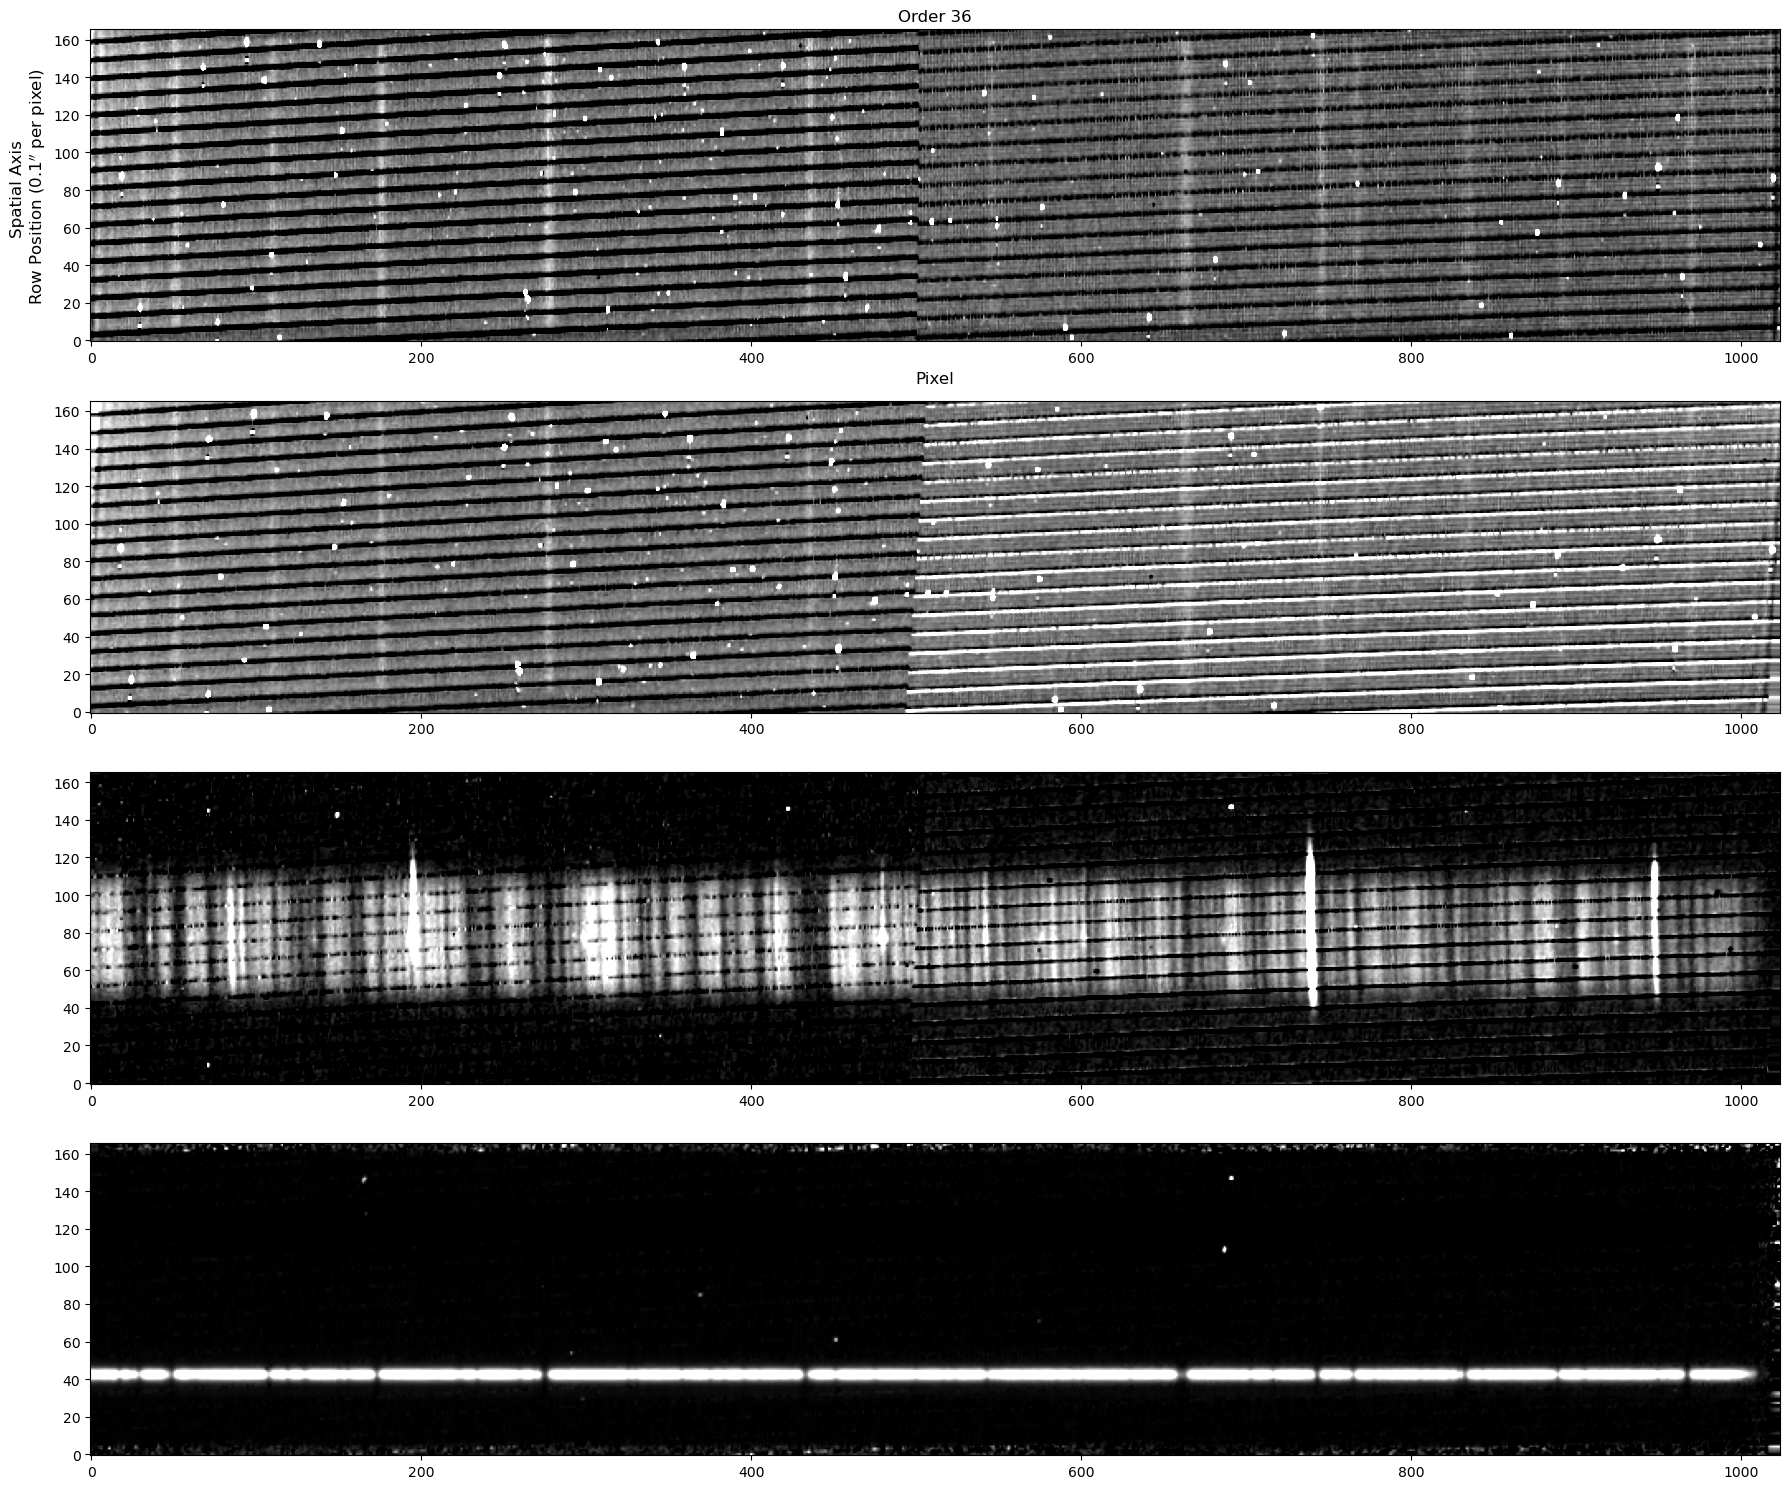

In [64]:
fig = plt.figure(figsize=(18, 15), tight_layout=True)

ax1 = fig.add_subplot(4,1,1)
ax1.imshow(order32_data[sky_frame[0]-int0],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=80), 
           origin='lower')
ax1.set_ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
ax1.set_xlabel('Pixel', fontsize=12)
ax1.set_title('Order 36', fontsize=12)

ax2 = fig.add_subplot(4,1,2)
ax2.imshow(order32_data[sky_frame[4]-int0],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=80), 
           origin='lower', 
           # extent=[wave32_h2[0], wave32_h2[-1], 0, spec32_h2[0].shape[0]],
          )

ax3 = fig.add_subplot(4,1,3)
ax3.imshow(order32_data[61 - int0] - order32_data[sky_frame[3]-int0],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=100), 
           origin='lower', 
           # extent=[wave32_h2[0], wave32_h2[-1], 0, spec32_h2[0].shape[0]],
          )

ax4 = fig.add_subplot(4,1,4)
ax4.imshow(modeAB32,
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.001), 
           origin='lower', 
           # extent=[wave32_h2[0], wave32_h2[-1], 0, spec32_h2[0].shape[0]],
          )

plt.show()

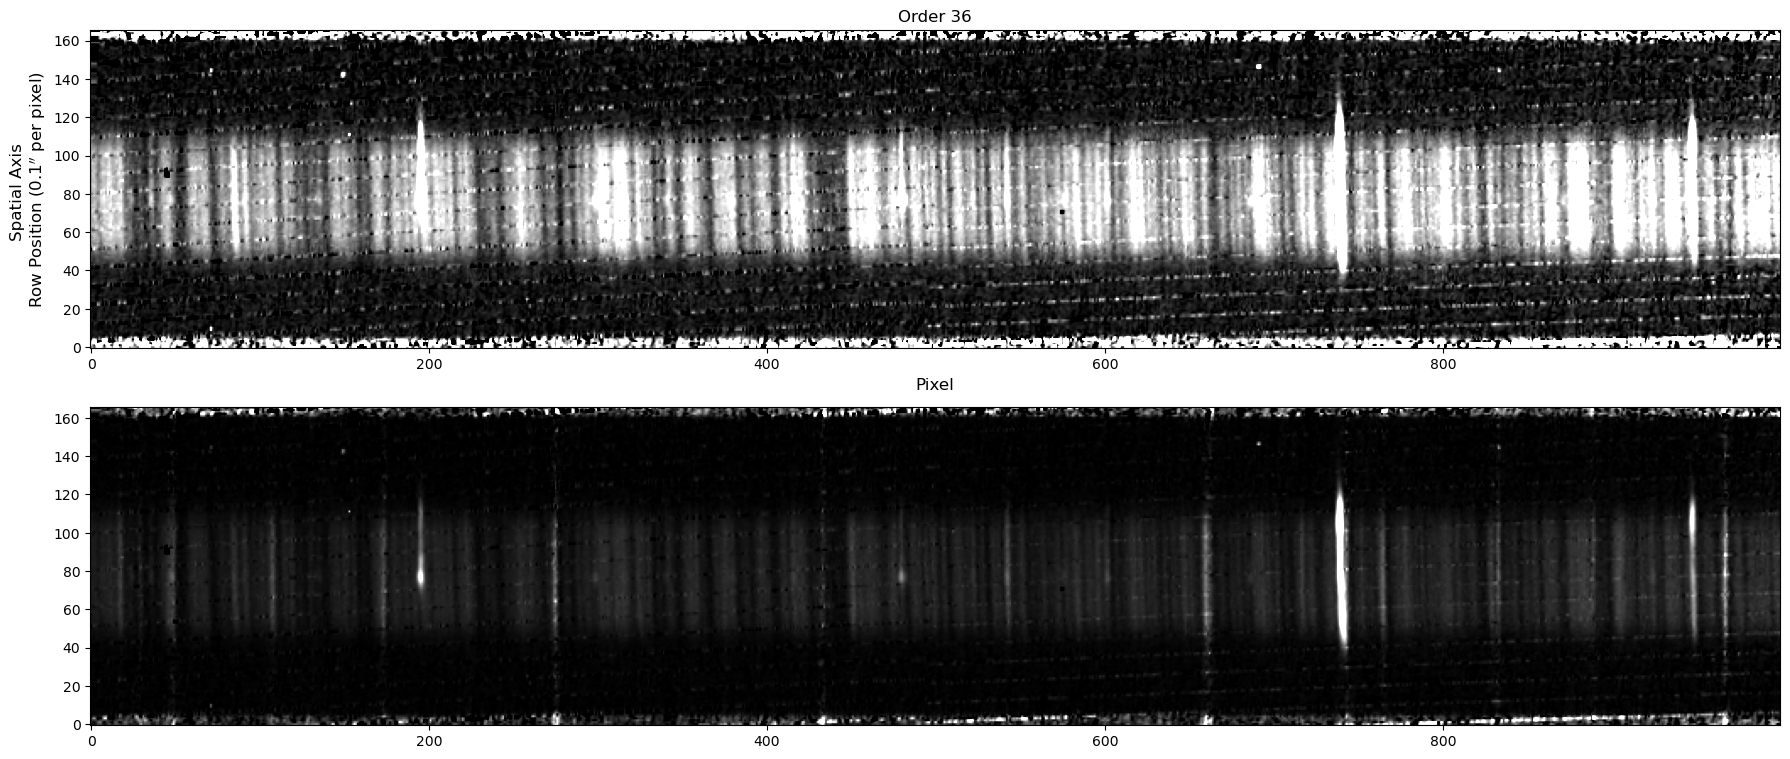

In [57]:
fig = plt.figure(figsize=(18, 15), tight_layout=True)

ax1 = fig.add_subplot(4,1,1)
ax1.imshow(spec32_reduced[0][:,:1000],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.01), 
           origin='lower')
ax1.set_ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
ax1.set_xlabel('Pixel', fontsize=12)
ax1.set_title('Order 36', fontsize=12)

Fobs32_new = star32_a0 * star32_a2*(np.sqrt(2*np.log(2))*2)
Fc32_new = Fbb32[:1000]/Fobs32_new

ax2 = fig.add_subplot(4,1,2)
ax2.imshow(spec32_reduced[0][:,:1000]/ exp_spec * Fc32_new * 4.2535e10 / slit_area32,
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.002), 
           origin='lower', 
           # extent=[wave32_h2[0], wave32_h2[-1], 0, spec32_h2[0].shape[0]],
          )

(700.0, 800.0)

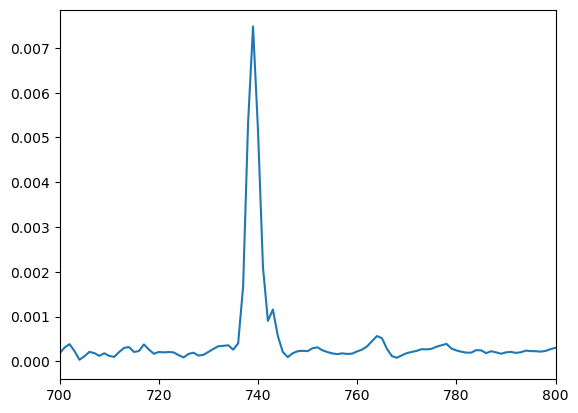

In [59]:
plt.plot((spec32_reduced[0][:,:1000]/ exp_spec * Fc32_new * 4.2535e10 / slit_area32)[100])
plt.xlim(700,800)

(0.0, 1000.0)

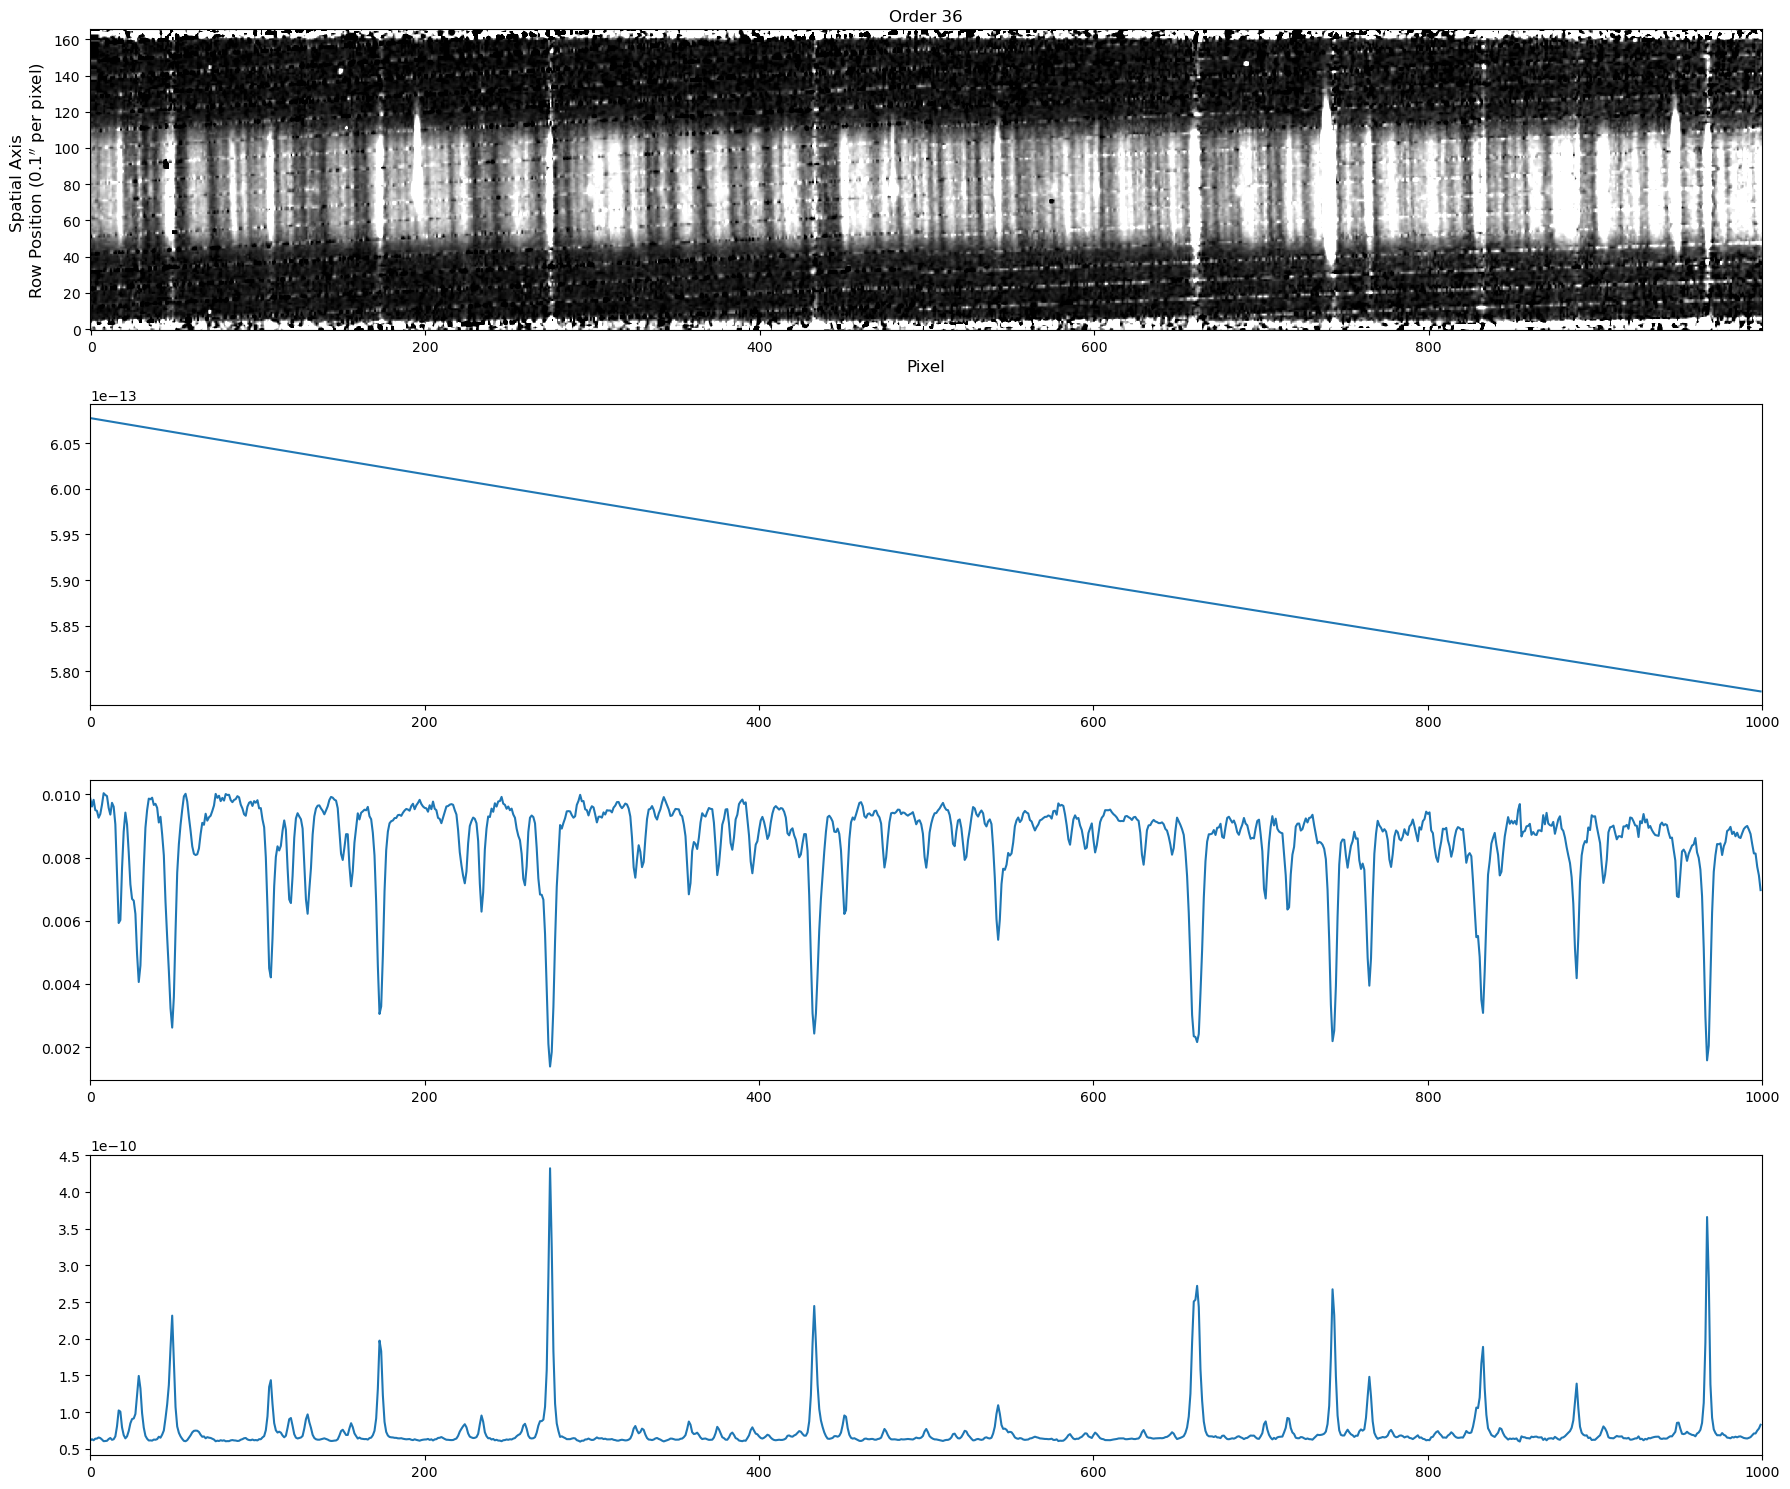

In [8]:
fig = plt.figure(figsize=(18, 15), tight_layout=True)

ax1 = fig.add_subplot(4,1,1)
ax1.imshow(fjc32[0][:,:1000],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.0003), 
           origin='lower')
ax1.set_ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
ax1.set_xlabel('Pixel', fontsize=12)
ax1.set_title('Order 36', fontsize=12)

ax2 = fig.add_subplot(4,1,2)
ax2.plot(Fbb32[:1000])
ax2.set_xlim(0,1000)

ax3 = fig.add_subplot(4,1,3)
ax3.plot(Fobs32[:1000])
ax3.set_xlim(0,1000)

ax4 = fig.add_subplot(4,1,4)
ax4.plot(Fc32[:1000])
ax4.set_xlim(0,1000)

Text(0.5, 0, 'Pixel')

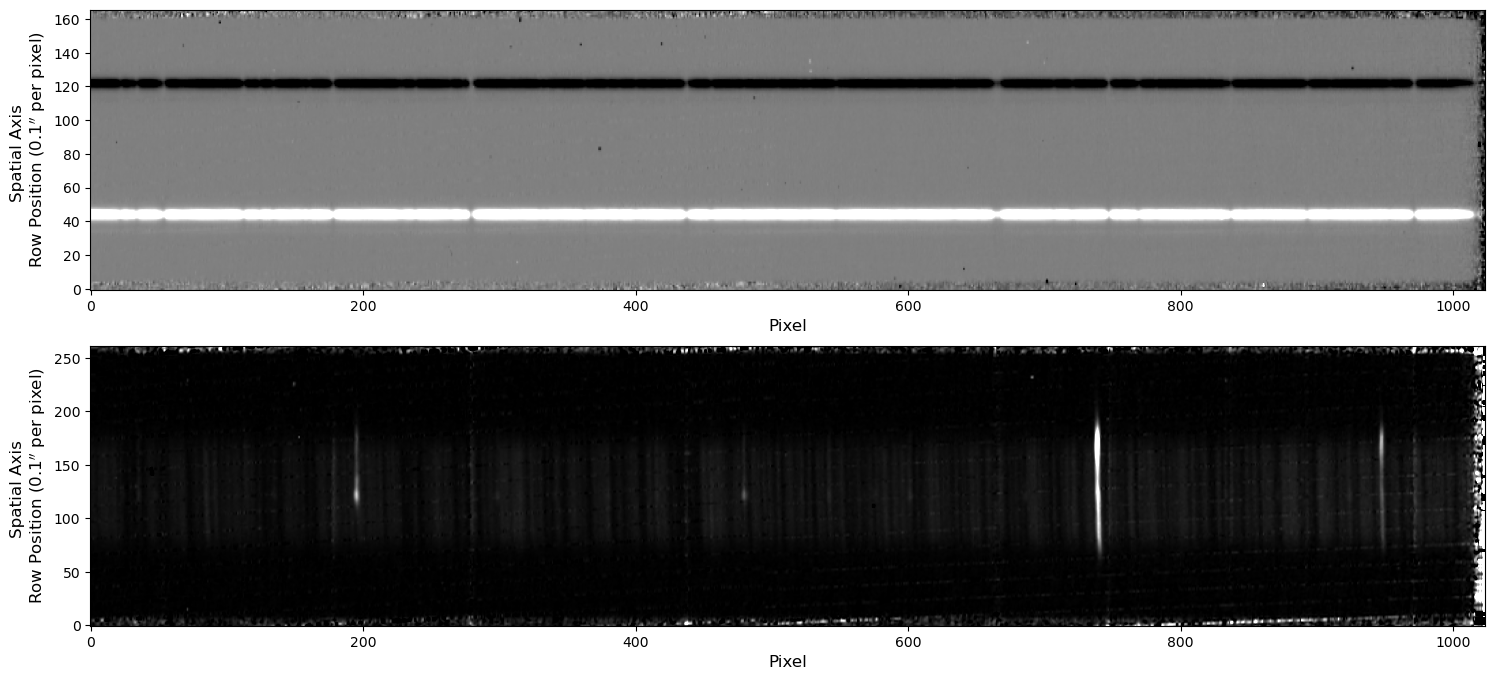

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1 , figsize=(18,8))

ax1.imshow(modeAB32,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=-0.001, vmax=0.001), 
           origin='lower')
ax1.set_ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
ax1.set_xlabel('Pixel', fontsize=12)

ax2.imshow(fjc32_rs[0],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.002), 
           origin='lower')
ax2.set_ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
ax2.set_xlabel('Pixel', fontsize=12)

BLANK LOOP START
DONE


Text(0.0, 1.0, 'a)')

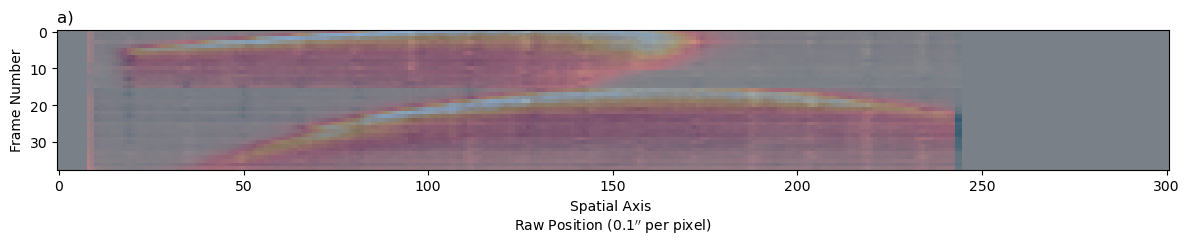

In [103]:
bg36 = fjc36_rs[:,:,210:240]
bg32 = fjc32_rs[:,:,200:230]
# plt.imshow(bg32)


# create empty list to collect result
bg_scan1 = []
bg_scan2 = []

fn0 = 0
fn1 = np.size(bg36,0)

upper = 245
lower = 10

print('BLANK LOOP START')
for fn in range(fn0, fn1):    
    stack1 = bg36[fn]
    stack2 = bg32[fn]
    
    blank1 = np.zeros(301)      
    blank2 = np.zeros(301)      
        
    # fit gaussian to selected range of spatial axis of a frame
    for i in range(lower, upper):               
            blank1[i] = np.median(stack1[i])
            blank2[i] = np.median(stack2[i])
    # Collect fitting parameters of each frame number   
    bg_scan1.append(blank1)
    bg_scan2.append(blank2)
    
print('DONE')

bg_raw1 = np.vstack(bg_scan1)
bg_raw2 = np.vstack(bg_scan2)


fig = plt.figure(figsize=(12,9), tight_layout=True)

fig.add_subplot(311)
plt.imshow(np.roll(bg_raw1,-2,axis=1), cmap='gist_heat', norm=colors.PowerNorm(gamma=1), alpha=0.9)
plt.imshow(bg_raw2, cmap='Blues', alpha=0.5)
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title('a)', loc='left')


# blank1 = np.zeros(301)      
# blank2 = np.zeros(301)

# lower = 20
# upper = 240

# # fit gaussian to selected range of spatial axis of a frame
# for i in range(lower, upper):               
#         blank1[i] = np.median(bg36[i])
#         blank2[i] = np.median(bg32[i])

Text(0.5, 0, 'Pixel')

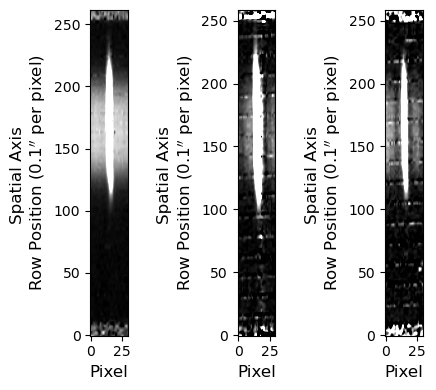

In [104]:
fig = plt.figure(figsize=(5,4), tight_layout=True)

fig.add_subplot(131)
plt.imshow(spec36_h2[:,:,81:111][16],
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.002), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(132)
plt.imshow(spec32_h2[:,:,725:755][16],
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.0005), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(133)
plt.imshow(spec32_h2[:,:,933:963][16],
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=1, vmin=0, vmax=0.0005), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

Text(0.5, 0, 'Pixel')

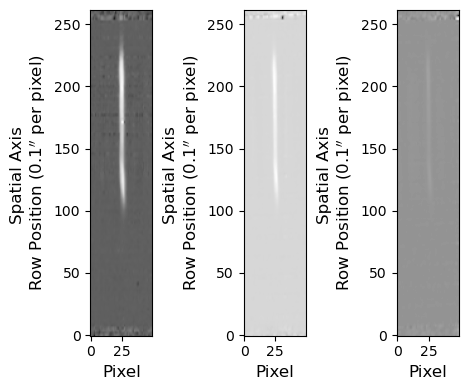

In [75]:
spec36_s1 = spec36_h2[:,:,71:121][17]
spec32_s1 = spec32_h2[:,:,715:765][17]
spec32_s2 = spec32_h2[:,:,923:973][17]

wave36_s1 = wave36_h2[71:121]
wave32_s1 = wave32_h2[715:765]
wave32_s2 = wave32_h2[923:973]

noise36_s1 = np.median(np.hstack((spec36_s1[:,3:8],spec36_s1[:,42:47])), axis=1)
reduced36_s1 = (spec36_s1.transpose() - noise36_s1).transpose()

noise32_s1 = np.median(np.hstack((spec32_s1[:,3:8],spec32_s1[:,42:47])), axis=1)
reduced32_s1 = (spec32_s1.transpose() - noise32_s1).transpose()

noise32_s2 = np.median(np.hstack((spec32_s2[:,3:8],spec32_s2[:,42:47])), axis=1)
reduced32_s2 = (spec32_s2.transpose() - noise32_s2).transpose()

# a = reduced36_s1[170]
# b = reduced36_s1[168]
# c = reduced36_s1[172]
# d = reduced36_s1[173]
# e = reduced36_s1[167]
# f = np.median((b, c, d, e), axis=0)
# reduced36_s1[169] = f * 1
# reduced36_s1[170] = f * 1
# reduced36_s1[171] = f * 1


fig = plt.figure(figsize=(5,4), tight_layout=True)

fig.add_subplot(131)
plt.imshow(reduced36_s1,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(132)
plt.imshow(reduced32_s1,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(133)
plt.imshow(reduced32_s2,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

In [76]:
smoo36_s1 = []
smoo32_s1 = []
smoo32_s2 = []

for j in range(1, len(reduced36_s1)-1):
    
    # addup36_s1 = np.mean((reduced36_s1[j-2],reduced36_s1[j-1],reduced36_s1[j],reduced36_s1[j+1],reduced36_s1[j+2]), axis=0)
    # addup32_s1 = np.mean((reduced32_s1[j-2],reduced32_s1[j-1],reduced32_s1[j],reduced32_s1[j+1],reduced32_s1[j+2]), axis=0)
    # addup32_s2 = np.mean((reduced32_s2[j-2],reduced32_s2[j-1],reduced32_s2[j],reduced32_s2[j+1],reduced32_s2[j+2]), axis=0)

    addup36_s1 = np.mean((reduced36_s1[j-1],reduced36_s1[j],reduced36_s1[j+1]), axis=0)
    addup32_s1 = np.mean((reduced32_s1[j-1],reduced32_s1[j],reduced32_s1[j+1]), axis=0)
    addup32_s2 = np.mean((reduced32_s2[j-1],reduced32_s2[j],reduced32_s2[j+1]), axis=0)
    
    smoo36_s1.append(addup36_s1)
    smoo32_s1.append(addup32_s1)
    smoo32_s2.append(addup32_s2)

smooth36_s1 = np.array(smoo36_s1)
smooth32_s1 = np.array(smoo32_s1)
smooth32_s2 = np.array(smoo32_s2)

Text(0.5, 0, 'Pixel')

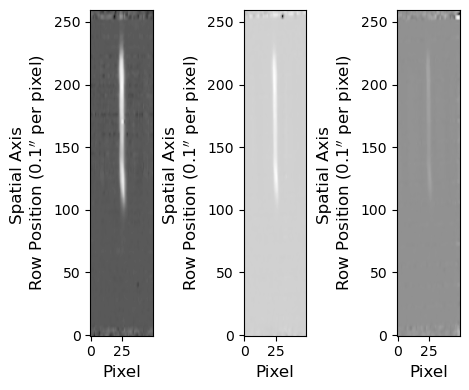

In [77]:
fig = plt.figure(figsize=(5,4), tight_layout=True)

fig.add_subplot(131)
plt.imshow(smooth36_s1,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(132)
plt.imshow(smooth32_s1,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(133)
plt.imshow(smooth32_s2,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

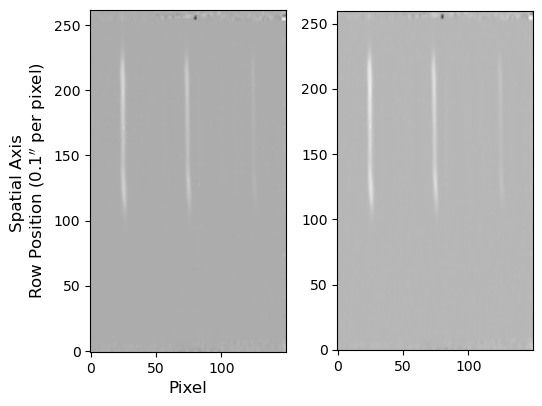

In [80]:
spec_to_fit = np.concatenate((reduced36_s1, reduced32_s1, reduced32_s2), axis=1)
smooth = np.concatenate((smooth36_s1, smooth32_s1, smooth32_s2), axis=1)

fig = plt.figure(figsize=(8,8), tight_layout=True)

fig.add_subplot(131)
plt.imshow(spec_to_fit,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

# fig.add_subplot(312)
# plt.plot(spec_to_fit[150])
# plt.legend()

fig.add_subplot(132)
plt.imshow(smooth,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')

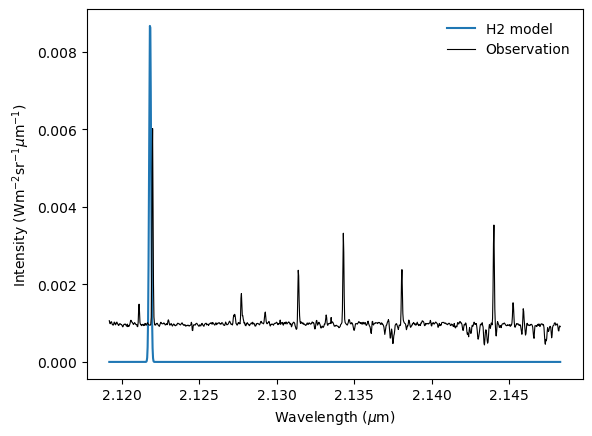

In [81]:
import h3ppy

# Create the H3+ object
h2 = h3ppy.h2()

# Define a wavelength range, e.g. typical of an observation of the H3+ Q branch
# Specify the start and end wavelengths, and the number of wavelength elements
wave = waverange36[:1001]
# spec = fjc36_rs[1][20:240,:1001][170]
spec = spec36_h2[16][150]

# Create a H3+ model spectrum for a set of physical parameters 
# Spectral resolution R = 1200, T = 1000, N = 1e14
# This is the minimum set of parameters required for generating a model
model = h2.model(density = 1e25, temperature = 850, R = 25000, wavelength = wave)

# Plot the model
fig, ax = plt.subplots()
ax.plot(wave, model, label = 'H2 model')
ax.plot(wave, spec,'k', lw=0.8, label = 'Observation')
# ax.set_xlim(2.405,2.415)
# ax.set_xlim(2.121,2.123)

# Automagically set the labels 
ax.set_xlabel(h2.xlabel())
ax.set_ylabel(h2.ylabel())
# plt.savefig('example_model.png')
# plt.close() 
ax.legend(frameon = False)

[h3ppy] Fit failed to converge - solution is numerially unstable 


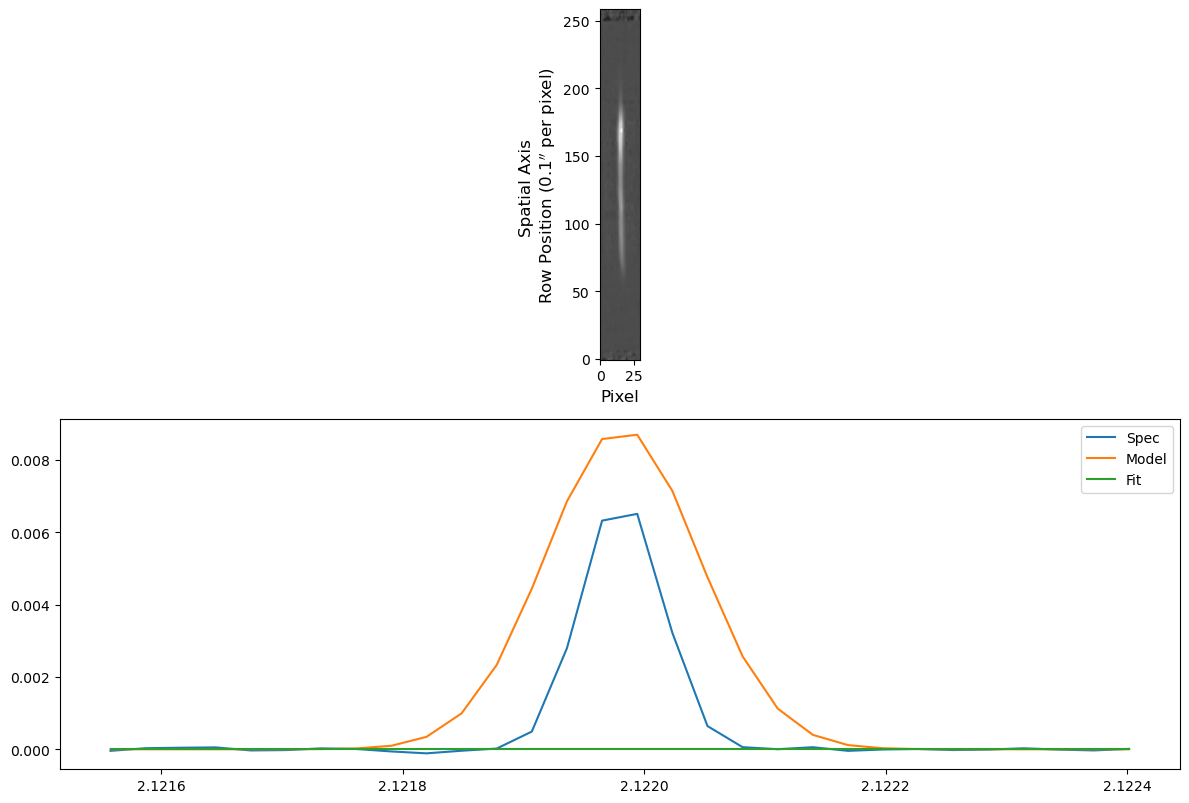

In [14]:
wav = wave36_s1
spe = reduced36_s1

h2 = h3ppy.h2()

order36_s1_off = 5.091855911964153
# order36_s1_off = 4.07551860948195

den = 1e25
tem = 850
res = 25000

model = h2.model(density = den, temperature = tem, R = res, wavelength = wav-(order36_s1_off*spec_scale36))
# model = h2.model(density = 1e22, temperature = 850, R = 25000, wavelength = wav)

h2.set(wavelength = wav, data = spe[150], R = res, density = den, temperature = tem)

fit = h2.fit(params_to_fit=['density','temperature'])
# vars, errs = h2.get_results()

fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spe,
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(312)
plt.plot(wav, spe[150], label='Spec')
plt.plot(wav, model, label='Model')
plt.plot(wav, fit, label='Fit')
plt.legend()

[h3ppy] Fit failed to converge - solution is numerially unstable 


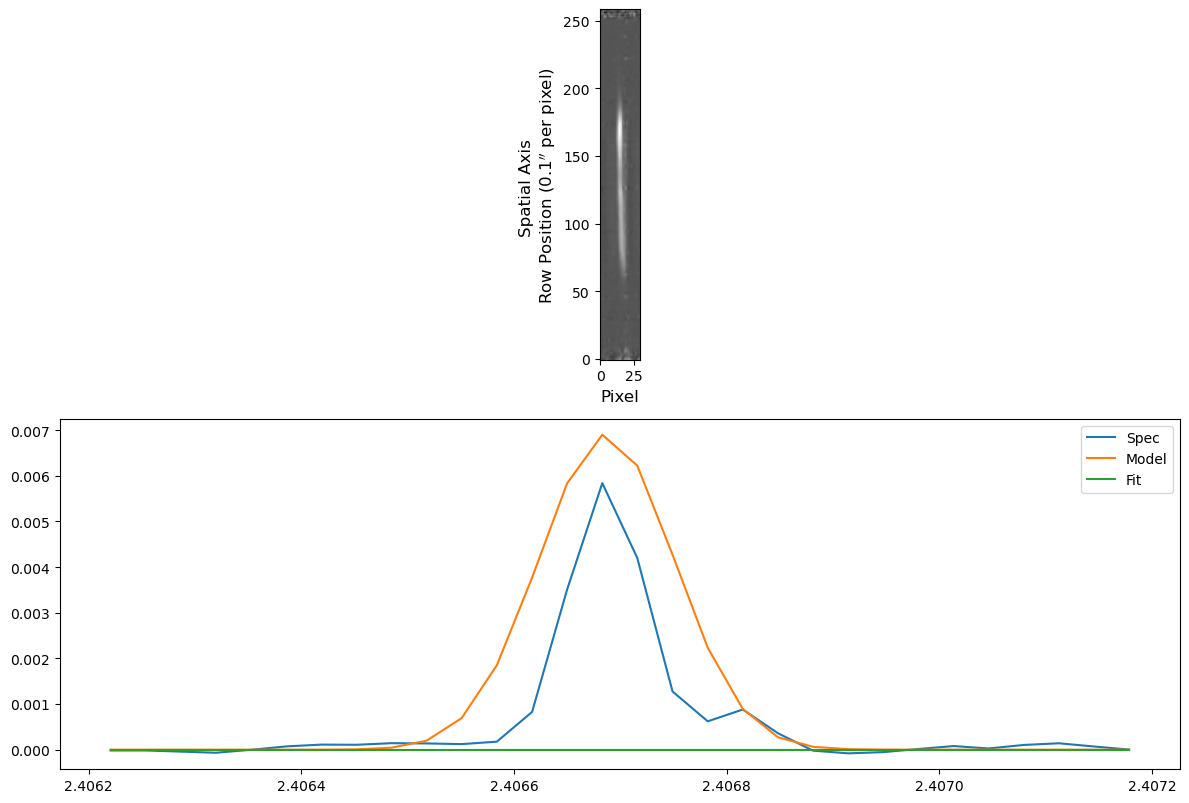

In [15]:
wav = wave32_s1
spe = reduced32_s1

h2 = h3ppy.h2()

order32_s1_off = 2.870631538701616

model = h2.model(density = 1e25, temperature = 850, R = 25000, wavelength = wav-(order32_s1_off*spec_scale32))
# model = h2.model(density = 1e22, temperature = 850, R = 25000, wavelength = wav)

h2.set(wavelength = wav, data = spe[150], R = 25000, density = 1e25, temperature = 850)

fit = h2.fit(params_to_fit=['density','temperature', 'offset_0', 'sigma_0', 'background_0'])
# vars, errs = h2.get_results()


fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spe,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(312)
plt.plot(wav, spe[150], label='Spec')
plt.plot(wav, model, label='Model')
plt.plot(wav, fit, label='Fit')
plt.legend()

[h3ppy] Fit failed to converge - solution is numerially unstable 


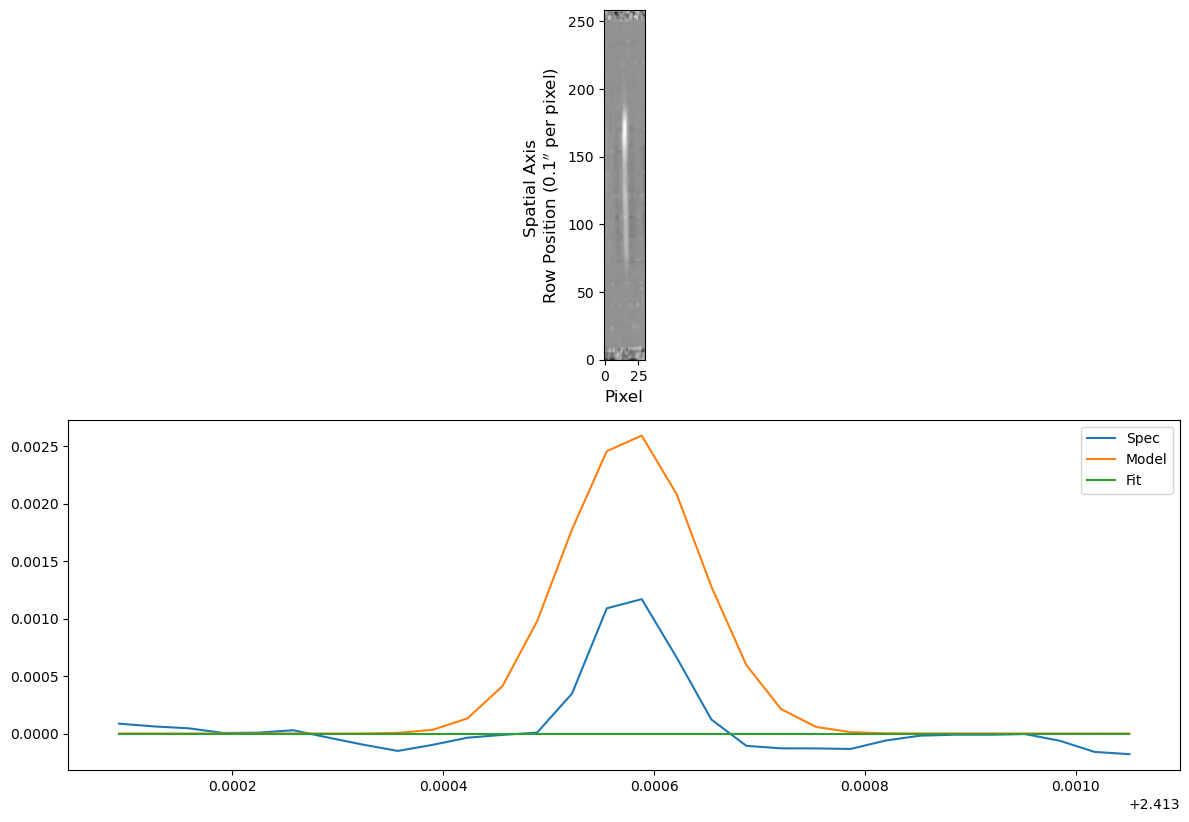

In [16]:
wav = wave32_s2
spe = reduced32_s2

h2 = h3ppy.h2()

order32_s2_off = 4.218302782737787

model = h2.model(density = 1e25, temperature = 850, R = 25000, wavelength = wav-(order32_s2_off*spec_scale32))
# model = h2.model(density = 1e22, temperature = 850, R = 25000, wavelength = wav)

h2.set(wavelength = wav, data = spe[150], R = 25000, density = 1e25, temperature = 850)

fit = h2.fit(params_to_fit=['density','temperature', 'offset_0', 'sigma_0', 'background_0'])
# vars, errs = h2.get_results()


fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spe,
#            extent=[waverange32[0],waverange32[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(312)
plt.plot(wav, spe[150], label='Spec')
plt.plot(wav, model, label='Model')
plt.plot(wav, fit, label='Fit')
plt.legend()

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 30
    # variables        = 6
    chi-square         = 8.1241e-12
    reduced chi-square = 3.3850e-13
    Akaike info crit   = -856.121458
    Bayesian info crit = -847.714273
    R-squared          = 0.99999941
[[Variables]]
    a0:  0.00229237 +/- 4.2650e-07 (0.02%) (init = 0.02)
    a1:  10.4766562 +/- 3.8298e-04 (0.00%) (init = 10)
    a2:  1.94623055 +/- 3.0431e-04 (0.02%) (init = 1)
    a3:  4.9779e-08 +/- 3.0595e-07 (614.62%) (init = 0)
    a4: -5.6972e-09 +/- 5.5773e-08 (978.96%) (init = 0)
    a5:  1.3531e-10 +/- 1.9632e-09 (1450.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.9717
    C(a3, a4) = -0.7072
    C(a3, a5) = +0.5540
    C(a2, a5) = +0.3856
    C(a0, a5) = +0.3390
    C(a2, a4) = -0.3246
    C(a0, a4) = -0.2979
    C(a0, a2) = -0.2003
    C(a1, a3) = +0.1978
    C(a1, a4) = -0.1877
    C

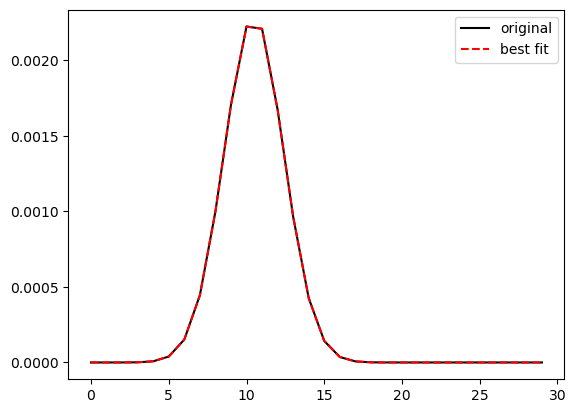

In [36]:
y = model
x = np.linspace(0,len(y)-1,len(y))

# create lmfit model with defined gaussian
m_model = Model(rhp.gaussian_fit)

# create parameters and add initial guess
m_params = m_model.make_params()
m_params.add('a0', value=0.02)
m_params.add('a1', value=10)
m_params.add('a2', value=1)
m_params.add('a3', value=0)
m_params.add('a4', value=0)
m_params.add('a5', value=0)

try:
    m_result = m_model.fit(y, m_params, x=x)
except:
    pass

print(m_result.fit_report())

plt.figure()
plt.plot(x, y, 'k', label='original')
plt.plot(x, m_result.best_fit, 'r--', label='best fit')
plt.legend()

print(m_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 30
    # variables        = 6
    chi-square         = 9.5113e-08
    reduced chi-square = 3.9630e-09
    Akaike info crit   = -575.081950
    Bayesian info crit = -566.674765
    R-squared          = 0.95542327
[[Variables]]
    a0:  0.00109800 +/- 5.5809e-05 (5.08%) (init = 0.02)
    a1:  14.6949590 +/- 0.06652409 (0.45%) (init = 15)
    a2:  1.41231439 +/- 0.05907580 (4.18%) (init = 1)
    a3:  7.2143e-05 +/- 3.3448e-05 (46.36%) (init = 0)
    a4: -1.8403e-05 +/- 6.1350e-06 (33.34%) (init = 0)
    a5:  4.6063e-07 +/- 2.0617e-07 (44.76%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.9762
    C(a3, a4) = -0.8285
    C(a3, a5) = +0.7209
    C(a2, a5) = +0.3679
    C(a2, a4) = -0.3606
    C(a0, a2) = -0.3522
    C(a0, a5) = +0.2564
    C(a0, a4) = -0.2512
    C(a2, a3) = +0.1664
    C(a0, a3) = +0.1239
14.694958

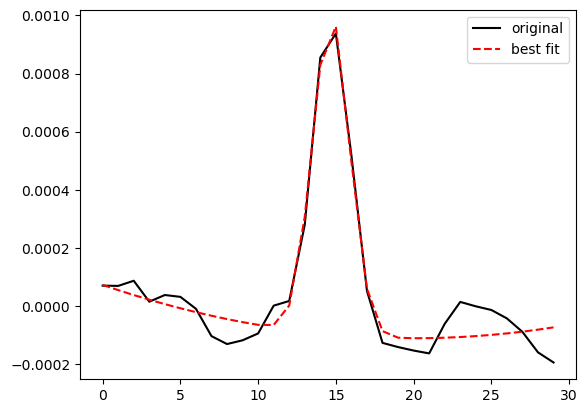

In [37]:
yy = spe[150]
xx = np.linspace(0,len(yy)-1,len(yy))


# create lmfit model with defined gaussian
s_model = Model(rhp.gaussian_fit)

# create parameters and add initial guess
s_params = s_model.make_params()
s_params.add('a0', value=0.02)
s_params.add('a1', value=15)
s_params.add('a2', value=1)
s_params.add('a3', value=0)
s_params.add('a4', value=0)
s_params.add('a5', value=0)

try:
    s_result = s_model.fit(yy, s_params, x=xx)
except:
    pass

print(s_result.fit_report())

plt.figure()
plt.plot(xx, yy, 'k', label='original')
plt.plot(xx, s_result.best_fit, 'r--', label='best fit')
plt.legend()

print(s_result.params['a1'].value)

In [38]:
s_result.params['a1'].value - m_result.params['a1'].value

4.218302782737787

In [137]:
spec36_s1_a1 = np.zeros(len(reduced36_s1))
spec36_s1_a1_error = np.zeros(len(reduced36_s1))

# yfit = reduced36_s1
yfit = smooth36_s1

xfit = np.linspace(0, 29, 30)

for i in range(20,240):
    spec36_s1_model = Model(rhp.gaussian_fit)

    spec36_s1_params = spec36_s1_model.make_params()
    spec36_s1_params.add('a0', value=0.003)
    spec36_s1_params.add('a1', value=15, min=11, max=19)
    spec36_s1_params.add('a2', value=1)
    spec36_s1_params.add('a3', value=0)
    spec36_s1_params.add('a4', value=0)
    spec36_s1_params.add('a5', value=0)

    try:
        spec36_s1_fit_result = spec36_s1_model.fit(yfit[i], spec36_s1_params, x=xfit)
    except ValueError:
        print('ValueError occured at i=' + str(i))
    # plt.figure()
    # plt.title('i='+str(i))
    # plt.plot(xfit, yfit[i])
    # plt.plot(xfit, spec36_s1_fit_result.best_fit, 'r-', label='best fit')

    spec36_s1_a1[i] = spec36_s1_fit_result.params['a1'].value
    spec36_s1_a1_error[i] = spec36_s1_fit_result.params['a1'].stderr

ValueError occured at i=58
ValueError occured at i=226
ValueError occured at i=227
ValueError occured at i=228
ValueError occured at i=233
ValueError occured at i=237


In [138]:
spec32_s1_a1 = np.zeros(len(reduced32_s1))
spec32_s1_a1_error = np.zeros(len(reduced32_s1))

# yfit = reduced32_s1
yfit = smooth32_s1

xfit = np.linspace(0, 29, 30)

for i in range(20,240):
    spec32_s1_model = Model(rhp.gaussian_fit)

    spec32_s1_params = spec32_s1_model.make_params()
    spec32_s1_params.add('a0', value=0.003)
    spec32_s1_params.add('a1', value=14.99, min=11, max=19)
    spec32_s1_params.add('a2', value=1)
    spec32_s1_params.add('a3', value=0)
    spec32_s1_params.add('a4', value=0)
    spec32_s1_params.add('a5', value=0)

    try:
        spec32_s1_fit_result = spec32_s1_model.fit(yfit[i], spec32_s1_params, x=xfit)
    except ValueError:
        print('ValueError occured at i=' + str(i))
#         plt.figure()
#         plt.title('i='+str(i))
#         plt.plot(xfit, yfit[i])
#         plt.plot(xfit, spec32_s1_fit_result.best_fit, 'r-', label='best fit')

    spec32_s1_a1[i] = spec32_s1_fit_result.params['a1'].value
    spec32_s1_a1_error[i] = spec32_s1_fit_result.params['a1'].stderr

ValueError occured at i=39
ValueError occured at i=40
ValueError occured at i=41
ValueError occured at i=42
ValueError occured at i=49
ValueError occured at i=50
ValueError occured at i=51
ValueError occured at i=52
ValueError occured at i=55
ValueError occured at i=56
ValueError occured at i=57
ValueError occured at i=58
ValueError occured at i=79
ValueError occured at i=189
ValueError occured at i=190
ValueError occured at i=221
ValueError occured at i=229


In [139]:
spec32_s2_a1 = np.zeros(len(reduced32_s2))
spec32_s2_a1_error = np.zeros(len(reduced32_s2))

# yfit = reduced32_s2
yfit = smooth32_s2

xfit = np.linspace(0, 29, 30)

for i in range(20,240):
    spec32_s2_model = Model(rhp.gaussian_fit)

    spec32_s2_params = spec32_s2_model.make_params()
    spec32_s2_params.add('a0', value=0.003)
    spec32_s2_params.add('a1', value=15, min=11, max=19)
    spec32_s2_params.add('a2', value=1)
    spec32_s2_params.add('a3', value=0)
    spec32_s2_params.add('a4', value=0)
    spec32_s2_params.add('a5', value=0)

    try:
        spec32_s2_fit_result = spec32_s2_model.fit(yfit[i], spec32_s2_params, x=xfit)
    except ValueError:
        print('ValueError occured at i=' + str(i))
#         plt.figure()
#         plt.title('i='+str(i))
#         plt.plot(xfit, yfit[i])
#         plt.plot(xfit, spec32_s2_fit_result.best_fit, 'r-', label='best fit')

    spec32_s2_a1[i] = spec32_s2_fit_result.params['a1'].value
    spec32_s2_a1_error[i] = spec32_s2_fit_result.params['a1'].stderr

ValueError occured at i=29
ValueError occured at i=37
ValueError occured at i=58
ValueError occured at i=60
ValueError occured at i=61
ValueError occured at i=62
ValueError occured at i=74
ValueError occured at i=75
ValueError occured at i=77
ValueError occured at i=142
ValueError occured at i=151
ValueError occured at i=168
ValueError occured at i=169
ValueError occured at i=197
ValueError occured at i=219
ValueError occured at i=221
ValueError occured at i=222
ValueError occured at i=223
ValueError occured at i=236
ValueError occured at i=237
ValueError occured at i=239


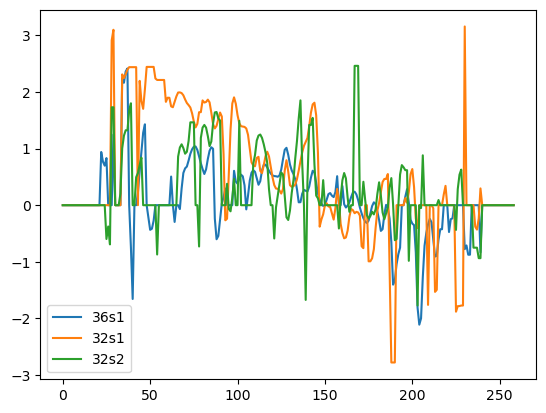

In [140]:
spec36_s1_offset = spec36_s1_a1 - spec36_s1_a1[150]
spec36_s1_offset[spec36_s1_a1_error > 0.5] = 0
spec36_s1_offset[spec36_s1_offset < -3] = 0
spec36_s1_offset[spec36_s1_offset > 4] = 0

spec32_s1_offset = spec32_s1_a1 - spec32_s1_a1[150]
spec32_s1_offset[spec32_s1_a1_error > 0.5] = 0
spec32_s1_offset[spec32_s1_offset < -3] = 0
spec32_s1_offset[spec32_s1_offset > 4] = 0

spec32_s2_offset = spec32_s2_a1 - spec32_s2_a1[150]
spec32_s2_offset[spec32_s2_a1_error > 0.5] = 0
spec32_s2_offset[spec32_s2_offset < -3] = 0
spec32_s2_offset[spec32_s2_offset > 4] = 0

plt.plot(spec36_s1_offset, label='36s1')
plt.plot(spec32_s1_offset, label='32s1')
plt.plot(spec32_s2_offset, label='32s2')
plt.legend()

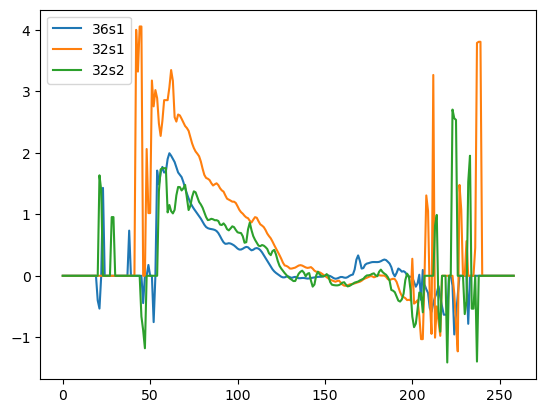

In [46]:
spec36_s1_offset = spec36_s1_a1 - spec36_s1_a1[150]
spec36_s1_offset[spec36_s1_a1_error > 0.5] = 0
spec36_s1_offset[spec36_s1_offset < -3] = 0

spec32_s1_offset = spec32_s1_a1 - spec32_s1_a1[150]
spec32_s1_offset[spec32_s1_a1_error > 0.5] = 0
spec32_s1_offset[spec32_s1_offset < -3] = 0 

spec32_s2_offset = spec32_s2_a1 - spec32_s2_a1[150]
spec32_s2_offset[spec32_s2_a1_error > 0.5] = 0
spec32_s2_offset[spec32_s2_offset < -3] = 0

plt.plot(spec36_s1_offset, label='36s1')
plt.plot(spec32_s1_offset, label='32s1')
plt.plot(spec32_s2_offset, label='32s2')
plt.legend()

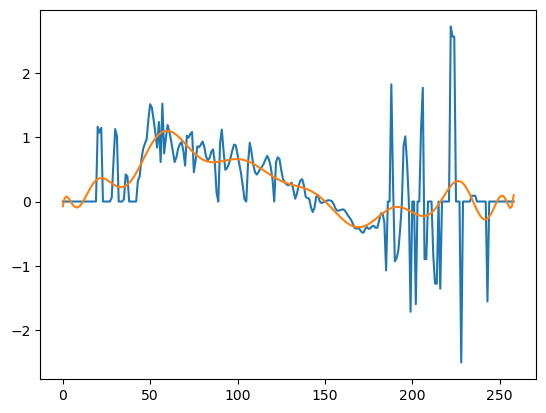

In [97]:
x = np.linspace(0,258,259)
z1 = np.poly1d(np.polyfit(x, spec36_s1_offset, 20))
z2 = np.poly1d(np.polyfit(x, spec32_s1_offset, 20))
z3 = np.poly1d(np.polyfit(x, spec32_s2_offset, 20))


# plt.plot(x, spec36_s1_offset)
# plt.plot(x, z1(x))
# plt.plot(x, spec32_s1_offset)
# plt.plot(x, z2(x))
plt.plot(x, spec32_s2_offset)
plt.plot(x, z3(x))

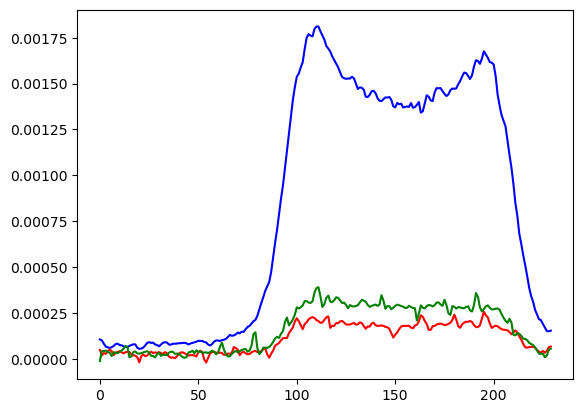

In [33]:
spec36_s1 = spec36_h2[:,4:263,81:111][19]
spec32_s1 = spec32_h2[:,:,725:755][19]
spec32_s2 = spec32_h2[:,:,933:963][19]

noise36_s1 = np.median(np.hstack((spec36_s1[:,0:5],spec36_s1[:,25:30])), axis=1)
noise32_s1 = np.median(np.hstack((spec32_s1[:,0:5],spec32_s1[:,25:30])), axis=1)
noise32_s2 = np.median(np.hstack((spec32_s2[:,0:5],spec32_s2[:,25:30])), axis=1)

plt.plot(noise36_s1[10:240], 'b-')
plt.plot(noise32_s1[10:240], 'r-')
plt.plot(noise32_s2[10:240], 'g-')

In [21]:
noise36_s1, noise32_s1, noise32_s2

(array([0.0017167 , 0.00166044, 0.00158552, 0.00145385, 0.00122043,
        0.00091637, 0.00067972, 0.00039251, 0.00024916, 0.000194  ,
        0.00014824, 0.00012827, 0.00011686, 0.00011211, 0.00011803,
        0.00013042, 0.0001328 , 0.00013614, 0.00013253, 0.00012923,
        0.00013511, 0.00014378, 0.00014762, 0.00015566, 0.00017644,
        0.00019571, 0.00021359, 0.00025585, 0.00029799, 0.00034527,
        0.00040559, 0.00045964, 0.00051502, 0.00058057, 0.00063812,
        0.00070277, 0.00076579, 0.00081281, 0.00083168, 0.00083771,
        0.00084454, 0.00083358, 0.00083214, 0.00082874, 0.00082044,
        0.00079865, 0.00077602, 0.00076793, 0.00075562, 0.00075103,
        0.00072957, 0.0006783 , 0.00067484, 0.00069416, 0.00069197,
        0.00068221, 0.00066473, 0.00065384, 0.00064168, 0.00063932,
        0.00064144, 0.00063743, 0.00062729, 0.00063567, 0.00062707,
        0.00062029, 0.00062113, 0.00061916, 0.00062345, 0.00061766,
        0.00058644, 0.00058034, 0.00055872, 0.00

In [19]:
spec36_s1 = spec36_h2[:,4:263,81:111][37]
spec32_s1 = spec32_h2[:,:,725:755][37]
spec32_s2 = spec32_h2[:,:,933:963][37]

wave36_s1 = wave36_h2[81:111]
wave32_s1 = wave32_h2[725:755]
wave32_s2 = wave32_h2[933:963]

noise36_s1 = np.median(np.hstack((spec36_s1[:,0:5],spec36_s1[:,25:30])), axis=1)
reduced36_s1 = (spec36_s1.transpose() - noise36_s1).transpose()

noise32_s1 = np.median(np.hstack((spec32_s1[:,0:5],spec32_s1[:,25:30])), axis=1)
reduced32_s1 = (spec32_s1.transpose() - noise32_s1).transpose()

noise32_s2 = np.median(np.hstack((spec32_s2[:,0:5],spec32_s2[:,25:30])), axis=1)
reduced32_s2 = (spec32_s2.transpose() - noise32_s2).transpose()

# x = np.linspace(0,258,259)
# z1 = np.poly1d(np.polyfit(x, spec36_s1_offset, 20))
# z2 = np.poly1d(np.polyfit(x, spec32_s1_offset, 20))
# z3 = np.poly1d(np.polyfit(x, spec32_s2_offset, 20))

order36_s1_off = 5.091855911964153
order32_s1_off = 2.870631538701616
order32_s2_off = 4.218302782737787

spec36_shifted_s1 = []
for i in range(len(reduced36_s1)):
    spec36_shifted_s1.append(scipy.ndimage.shift(reduced36_s1[i], -spec36_s1_offset[i]))
order36_s1 = np.array(spec36_shifted_s1)

spec32_shifted_s1 = []
for i in range(len(reduced32_s1)):
    spec32_shifted_s1.append(scipy.ndimage.shift(reduced32_s1[i], -spec32_s1_offset[i]))
order32_s1 = np.array(spec32_shifted_s1)

spec32_shifted_s2 = []
for i in range(len(reduced32_s2)):
    spec32_shifted_s2.append(scipy.ndimage.shift(reduced32_s2[i], -spec32_s2_offset[i]))
order32_s2 = np.array(spec32_shifted_s2)

spec_to_fit = np.concatenate((order36_s1, order32_s1, order32_s2), axis=1)

wave36_s1 = wave36_s1 - (order36_s1_off * spec_scale36)
wave32_s1 = wave32_s1 - (order32_s1_off * spec_scale32)
wave32_s2 = wave32_s2 - (order32_s2_off * spec_scale32)

wave_to_fit = np.concatenate((wave36_s1, wave32_s1, wave32_s2),)

fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spec_to_fit,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(312)
plt.plot(spec_to_fit[150])

NameError: name 'spec36_s1_offset' is not defined

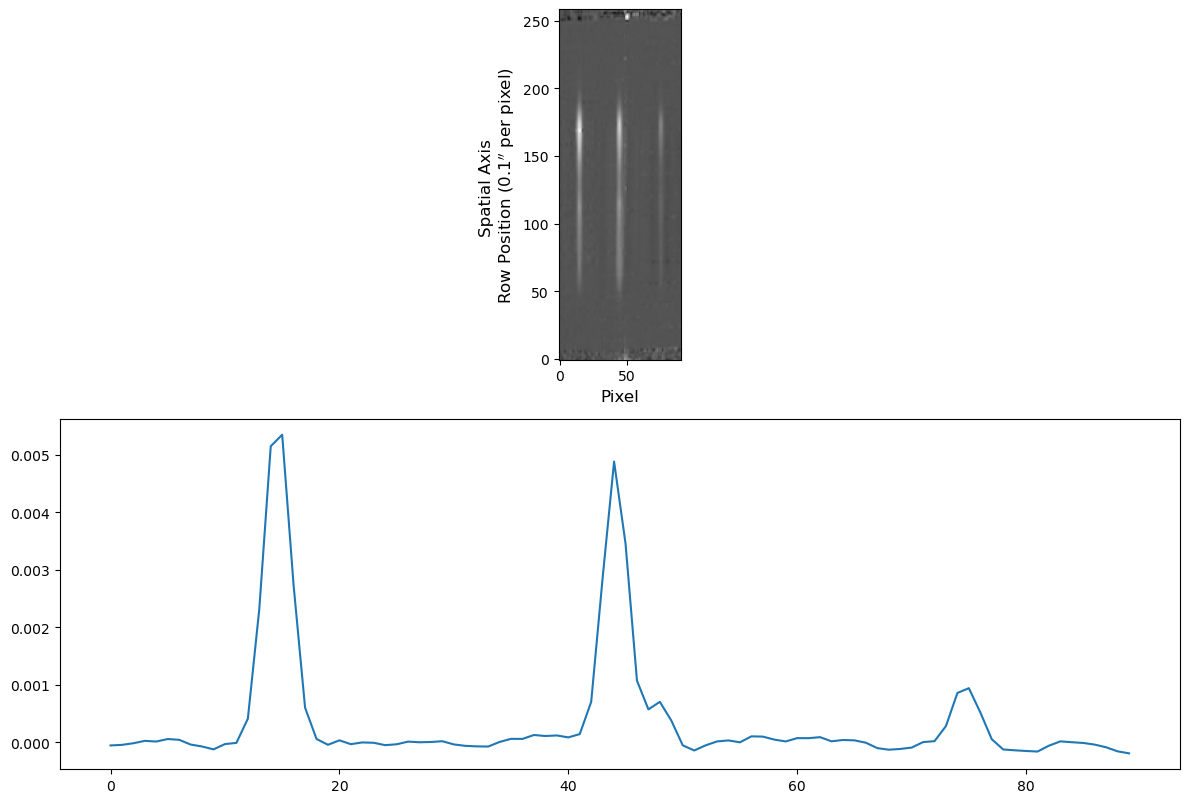

In [97]:
spec36_s1 = spec36_h2[4:263,81:111]
spec32_s1 = spec32_h2[:,725:755]
spec32_s2 = spec32_h2[:,933:963]

wave36_s1 = wave36_h2[81:111]
wave32_s1 = wave32_h2[725:755]
wave32_s2 = wave32_h2[933:963]

noise36_s1 = np.median(np.hstack((spec36_s1[:,0:5],spec36_s1[:,25:30])), axis=1)
reduced36_s1 = (spec36_s1.transpose() - noise36_s1).transpose()

noise32_s1 = np.median(np.hstack((spec32_s1[:,0:5],spec32_s1[:,25:30])), axis=1)
reduced32_s1 = (spec32_s1.transpose() - noise32_s1).transpose()

noise32_s2 = np.median(np.hstack((spec32_s2[:,0:5],spec32_s2[:,25:30])), axis=1)
reduced32_s2 = (spec32_s2.transpose() - noise32_s2).transpose()

spec36_shifted_s1 = []
for i in range(len(reduced36_s1)):
    spec36_shifted_s1.append(scipy.ndimage.shift(reduced36_s1[i], -spec36_s1_offset[i]))
order36_s1 = np.array(spec36_shifted_s1)

spec32_shifted_s1 = []
for i in range(len(reduced32_s1)):
    spec32_shifted_s1.append(scipy.ndimage.shift(reduced32_s1[i], -spec32_s1_offset[i]))
order32_s1 = np.array(spec32_shifted_s1)

spec32_shifted_s2 = []
for i in range(len(reduced32_s2)):
    spec32_shifted_s2.append(scipy.ndimage.shift(reduced32_s2[i], -spec32_s2_offset[i]))
order32_s2 = np.array(spec32_shifted_s2)

spec_to_fit = np.concatenate((order36_s1, order32_s1, order32_s2), axis=1)

wave36_s1 = wave36_s1 - (order36_s1_off * spec_scale36)
wave32_s1 = wave32_s1 - (order32_s1_off * spec_scale32)
wave32_s2 = wave32_s2 - (order32_s2_off * spec_scale32)

wave_to_fit = np.concatenate((wave36_s1, wave32_s1, wave32_s2),)

fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spec_to_fit,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

fig.add_subplot(312)
plt.plot(spec_to_fit[150])

[h3ppy]  Spectrum parameters:
         Temperature    = 797.5 +/- 17.8 [K]
         Column density = 8.82E+24 +/-  2.15E+24 [m-2]
         ------------------------------
         background_0 = 0.00E+00
         offset_0 = 0.00E+00
         sigma_0 = 3.69E-05



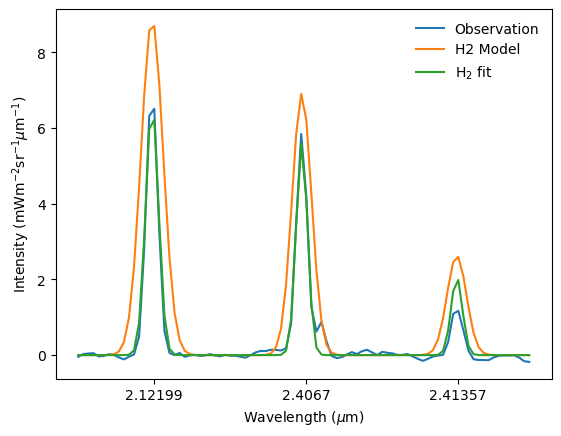

In [37]:
centers = [2.12199, 2.4067, 2.41357]
cpos = np.arange(3) * 30 + 15

h2 = h3ppy.h2()

wave = wave_to_fit
spec = spec_to_fit[150]

temp = 850
dens = 1e25
res = 25000

model = h2.model(density = dens, temperature = temp, R = res, wavelength = wave)

h2.set(wavelength = wave, data = spec, R = res, density = dens, temperature = temp)

# h2.guess_density()
fit = h2.fit(params_to_fit=['density','temperature'])
vars, errs = h2.get_results()

xx = range(len(spec))

# fig = plt.figure(figsize=(12,12), tight_layout=True)

# fig.add_subplot(312)
# # plt.plot(wave_to_fit, spec_to_fit[120], label='Spec')
# plt.plot(wave_to_fit, model, label='Model')
# # plt.plot(wave_to_fit, fit, label='Fit')
# plt.legend()

# Plot the fit
fig, ax = plt.subplots()
ax.plot(xx, spec * 1e3, '-', label = 'Observation')
ax.plot(xx, model * 1e3, '-', label = 'H2 Model')
ax.plot(xx, fit * 1e3, label = 'H$_2$ fit')
ax.set(xlabel = h2.xlabel(), ylabel = h2.ylabel(prefix = 'm'), xticks = cpos)
ax.set_xticklabels(centers)
ax.legend(frameon = False)

In [149]:
spec_set = []

for fn in range(len(fjc36_rs)):
    print('fn = '+str(fn))
    
    spec36_h2 = np.concatenate((fjc36_rs[fn][:,:101],fjc36_rs[fn][:,189:201], fjc36_rs[fn][:,113:1001]), axis=1)
    wave36_h2 = waverange36[:1001]
    
    spec32_h2 = fjc32_rs[fn][:,:1001]
    wave32_h2 = waverange32[:1001]
    
    spec36_s1 = spec36_h2[4:263,81:111]
    spec32_s1 = spec32_h2[:,725:755]
    spec32_s2 = spec32_h2[:,933:963]

    wave36_s1 = wave36_h2[81:111]
    wave32_s1 = wave32_h2[725:755]
    wave32_s2 = wave32_h2[933:963]
    
    order36_s1_off = 5.091855911964153
    order32_s1_off = 2.870631538701616
    order32_s2_off = 4.218302782737787

    noise36_s1 = np.median(np.hstack((spec36_s1[:,0:5],spec36_s1[:,25:30])), axis=1)
    reduced36_s1 = (spec36_s1.transpose() - noise36_s1).transpose()

    noise32_s1 = np.median(np.hstack((spec32_s1[:,0:5],spec32_s1[:,25:30])), axis=1)
    reduced32_s1 = (spec32_s1.transpose() - noise32_s1).transpose()

    noise32_s2 = np.median(np.hstack((spec32_s2[:,0:5],spec32_s2[:,25:30])), axis=1)
    reduced32_s2 = (spec32_s2.transpose() - noise32_s2).transpose()

    smoo36_s1 = []
    smoo32_s1 = []
    smoo32_s2 = []
    
    for j in range(2, len(reduced36_s1)-2):
        
        addup36_s1 = np.mean((reduced36_s1[j-2],reduced36_s1[j-1],reduced36_s1[j],reduced36_s1[j+1],reduced36_s1[j+2]), axis=0)
        addup32_s1 = np.mean((reduced32_s1[j-2],reduced32_s1[j-1],reduced32_s1[j],reduced32_s1[j+1],reduced32_s1[j+2]), axis=0)
        addup32_s2 = np.mean((reduced32_s2[j-2],reduced32_s2[j-1],reduced32_s2[j],reduced32_s2[j+1],reduced32_s2[j+2]), axis=0)
        
        smoo36_s1.append(addup36_s1)
        smoo32_s1.append(addup32_s1)
        smoo32_s2.append(addup32_s2)
    
    smooth36_s1 = np.array(smoo36_s1)
    smooth32_s1 = np.array(smoo32_s1)
    smooth32_s2 = np.array(smoo32_s2)
    
    
    spec36_s1_a1 = np.zeros(len(reduced36_s1))
    spec36_s1_a1_error = np.zeros(len(reduced36_s1))

    yfit = smooth36_s1

    xfit = np.linspace(0, 29, 30)

    for i in range(10,250):
        spec36_s1_model = Model(rhp.gaussian_fit)

        spec36_s1_params = spec36_s1_model.make_params()
        spec36_s1_params.add('a0', value=0.003)
        spec36_s1_params.add('a1', value=15, min=10)
        spec36_s1_params.add('a2', value=1)
        spec36_s1_params.add('a3', value=0)
        spec36_s1_params.add('a4', value=0)
        spec36_s1_params.add('a5', value=0)

        try:
            spec36_s1_fit_result = spec36_s1_model.fit(yfit[i], spec36_s1_params, x=xfit)
        except ValueError:
            pass

        spec36_s1_a1[i] = spec36_s1_fit_result.params['a1'].value
        spec36_s1_a1_error[i] = spec36_s1_fit_result.params['a1'].stderr
    
    
    spec32_s1_a1 = np.zeros(len(reduced32_s1))
    spec32_s1_a1_error = np.zeros(len(reduced32_s1))

    yfit = smooth32_s1

    xfit = np.linspace(0, 29, 30)

    for i in range(10,250):
        spec32_s1_model = Model(rhp.gaussian_fit)

        spec32_s1_params = spec32_s1_model.make_params()
        spec32_s1_params.add('a0', value=0.003)
        spec32_s1_params.add('a1', value=14.99, min=10)
        spec32_s1_params.add('a2', value=1)
        spec32_s1_params.add('a3', value=0)
        spec32_s1_params.add('a4', value=0)
        spec32_s1_params.add('a5', value=0)

        try:
            spec32_s1_fit_result = spec32_s1_model.fit(yfit[i], spec32_s1_params, x=xfit)
        except ValueError:
            pass

        spec32_s1_a1[i] = spec32_s1_fit_result.params['a1'].value
        spec32_s1_a1_error[i] = spec32_s1_fit_result.params['a1'].stderr
        
        
    spec32_s2_a1 = np.zeros(len(reduced32_s2))
    spec32_s2_a1_error = np.zeros(len(reduced32_s2))

    yfit = smooth32_s2

    xfit = np.linspace(0, 29, 30)

    for i in range(10,250):
        spec32_s2_model = Model(rhp.gaussian_fit)

        spec32_s2_params = spec32_s2_model.make_params()
        spec32_s2_params.add('a0', value=0.003)
        spec32_s2_params.add('a1', value=15, min=10)
        spec32_s2_params.add('a2', value=1)
        spec32_s2_params.add('a3', value=0)
        spec32_s2_params.add('a4', value=0)
        spec32_s2_params.add('a5', value=0)

        try:
            spec32_s2_fit_result = spec32_s2_model.fit(yfit[i], spec32_s2_params, x=xfit)
        except ValueError:
            pass

        spec32_s2_a1[i] = spec32_s2_fit_result.params['a1'].value
        spec32_s2_a1_error[i] = spec32_s2_fit_result.params['a1'].stderr
        
    
    spec36_s1_offset = spec36_s1_a1 - spec36_s1_a1[150]
    spec36_s1_offset[spec36_s1_a1_error > 0.5] = 0
    spec36_s1_offset[spec36_s1_offset < -3] = 0
    spec36_s1_offset[spec36_s1_offset > 4] = 0

    spec32_s1_offset = spec32_s1_a1 - spec32_s1_a1[150]
    spec32_s1_offset[spec32_s1_a1_error > 0.5] = 0
    spec32_s1_offset[spec32_s1_offset < -3] = 0
    spec32_s1_offset[spec32_s1_offset > 4] = 0

    spec32_s2_offset = spec32_s2_a1 - spec32_s2_a1[150]
    spec32_s2_offset[spec32_s2_a1_error > 0.5] = 0
    spec32_s2_offset[spec32_s2_offset < -3] = 0
    spec32_s2_offset[spec32_s2_offset > 4] = 0

    # x = np.linspace(0,258,259)
    # z1 = np.poly1d(np.polyfit(x, spec36_s1_offset, 20))
    # z2 = np.poly1d(np.polyfit(x, spec32_s1_offset, 20))
    # z3 = np.poly1d(np.polyfit(x, spec32_s2_offset, 20))
        
        
    spec36_shifted_s1 = []
    for i in range(len(reduced36_s1)):
        spec36_shifted_s1.append(scipy.ndimage.shift(reduced36_s1[i], -spec36_s1_offset[i]))
    order36_s1 = np.array(spec36_shifted_s1)

    spec32_shifted_s1 = []
    for i in range(len(reduced32_s1)):
        spec32_shifted_s1.append(scipy.ndimage.shift(reduced32_s1[i], -spec32_s1_offset[i]))
    order32_s1 = np.array(spec32_shifted_s1)

    spec32_shifted_s2 = []
    for i in range(len(reduced32_s2)):
        spec32_shifted_s2.append(scipy.ndimage.shift(reduced32_s2[i], -spec32_s2_offset[i]))
    order32_s2 = np.array(spec32_shifted_s2)

    spec_to_fit = np.concatenate((order36_s1, order32_s1, order32_s2), axis=1)

    wave36_s1 = wave36_s1 - (order36_s1_off * spec_scale36)
    wave32_s1 = wave32_s1 - (order32_s1_off * spec_scale32)
    wave32_s2 = wave32_s2 - (order32_s2_off * spec_scale32)

    wave_to_fit = np.concatenate((wave36_s1, wave32_s1, wave32_s2),)
    

    spec_set.append(spec_to_fit)
    
spec_smoothed = np.array(spec_set)

fn = 0
fn = 1
fn = 2
fn = 3
fn = 4
fn = 5
fn = 6
fn = 7
fn = 8
fn = 9
fn = 10
fn = 11
fn = 12
fn = 13
fn = 14
fn = 15
fn = 16
fn = 17
fn = 18
fn = 19
fn = 20
fn = 21
fn = 22
fn = 23
fn = 24
fn = 25
fn = 26
fn = 27
fn = 28
fn = 29
fn = 30
fn = 31
fn = 32
fn = 33
fn = 34
fn = 35
fn = 36
fn = 37


Text(0.5, 0, 'Pixel')

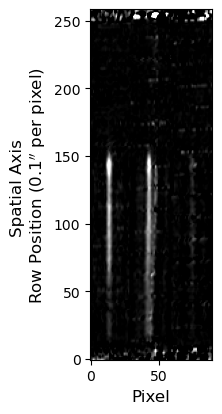

In [150]:
fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spec_smoothed[15],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           vmax=0.001,
           vmin=0,
           # norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

In [44]:
spec_set = []

for fn in range(len(fjc36_rs)):
    print('fn = '+str(fn))
    
    spec36_h2 = np.concatenate((fjc36_rs[fn][:,:101],fjc36_rs[fn][:,189:201], fjc36_rs[fn][:,113:1001]), axis=1)
    wave36_h2 = waverange36[:1001]
    
    spec32_h2 = fjc32_rs[fn][:,:1001]
    wave32_h2 = waverange32[:1001]
    
    spec36_s1 = spec36_h2[4:263,81:111]
    spec32_s1 = spec32_h2[:,725:755]
    spec32_s2 = spec32_h2[:,933:963]

    wave36_s1 = wave36_h2[81:111]
    wave32_s1 = wave32_h2[725:755]
    wave32_s2 = wave32_h2[933:963]
    
    order36_s1_off = 5.091855911964153
    order32_s1_off = 2.870631538701616
    order32_s2_off = 4.218302782737787

    noise36_s1 = np.median(np.hstack((spec36_s1[:,0:5],spec36_s1[:,25:30])), axis=1)
    reduced36_s1 = (spec36_s1.transpose() - noise36_s1).transpose()

    noise32_s1 = np.median(np.hstack((spec32_s1[:,0:5],spec32_s1[:,25:30])), axis=1)
    reduced32_s1 = (spec32_s1.transpose() - noise32_s1).transpose()

    noise32_s2 = np.median(np.hstack((spec32_s2[:,0:5],spec32_s2[:,25:30])), axis=1)
    reduced32_s2 = (spec32_s2.transpose() - noise32_s2).transpose()
    
    
    spec36_s1_a1 = np.zeros(len(reduced36_s1))
    spec36_s1_a1_error = np.zeros(len(reduced36_s1))

    yfit = reduced36_s1

    xfit = np.linspace(0, 29, 30)

    for i in range(20,250):
        spec36_s1_model = Model(rhp.gaussian_fit)

        spec36_s1_params = spec36_s1_model.make_params()
        spec36_s1_params.add('a0', value=0.005)
        spec36_s1_params.add('a1', value=15)
        spec36_s1_params.add('a2', value=1)
        spec36_s1_params.add('a3', value=0)
        spec36_s1_params.add('a4', value=0)
        spec36_s1_params.add('a5', value=0)

        try:
            spec36_s1_fit_result = spec36_s1_model.fit(yfit[i], spec36_s1_params, x=xfit)
        except ValueError:
            pass

        spec36_s1_a1[i] = spec36_s1_fit_result.params['a1'].value
        spec36_s1_a1_error[i] = spec36_s1_fit_result.params['a1'].stderr
    
    
    spec32_s1_a1 = np.zeros(len(reduced32_s1))
    spec32_s1_a1_error = np.zeros(len(reduced32_s1))

    yfit = reduced32_s1

    xfit = np.linspace(0, 29, 30)

    for i in range(20,250):
        spec32_s1_model = Model(rhp.gaussian_fit)

        spec32_s1_params = spec32_s1_model.make_params()
        spec32_s1_params.add('a0', value=0.003)
        spec32_s1_params.add('a1', value=14.99)
        spec32_s1_params.add('a2', value=1)
        spec32_s1_params.add('a3', value=0)
        spec32_s1_params.add('a4', value=0)
        spec32_s1_params.add('a5', value=0)

        try:
            spec32_s1_fit_result = spec32_s1_model.fit(yfit[i], spec32_s1_params, x=xfit)
        except ValueError:
            pass

        spec32_s1_a1[i] = spec32_s1_fit_result.params['a1'].value
        spec32_s1_a1_error[i] = spec32_s1_fit_result.params['a1'].stderr
        
        
    spec32_s2_a1 = np.zeros(len(reduced32_s2))
    spec32_s2_a1_error = np.zeros(len(reduced32_s2))

    yfit = reduced32_s2

    xfit = np.linspace(0, 29, 30)

    for i in range(20,250):
        spec32_s2_model = Model(rhp.gaussian_fit)

        spec32_s2_params = spec32_s2_model.make_params()
        spec32_s2_params.add('a0', value=0.003)
        spec32_s2_params.add('a1', value=15)
        spec32_s2_params.add('a2', value=1)
        spec32_s2_params.add('a3', value=0)
        spec32_s2_params.add('a4', value=0)
        spec32_s2_params.add('a5', value=0)

        try:
            spec32_s2_fit_result = spec32_s2_model.fit(yfit[i], spec32_s2_params, x=xfit)
        except ValueError:
            pass

        spec32_s2_a1[i] = spec32_s2_fit_result.params['a1'].value
        spec32_s2_a1_error[i] = spec32_s2_fit_result.params['a1'].stderr
        
    
    spec36_s1_offset = spec36_s1_a1 - spec36_s1_a1[150]
    spec36_s1_offset[spec36_s1_a1_error > 0.5] = 0
    spec36_s1_offset[spec36_s1_offset < -3] = 0

    spec32_s1_offset = spec32_s1_a1 - spec32_s1_a1[150]
    spec32_s1_offset[spec32_s1_a1_error > 0.5] = 0
    spec32_s1_offset[spec32_s1_offset < -3] = 0 

    spec32_s2_offset = spec32_s2_a1 - spec32_s2_a1[150]
    spec32_s2_offset[spec32_s2_a1_error > 0.5] = 0
    spec32_s2_offset[spec32_s2_offset < -3] = 0
        
        
    spec36_shifted_s1 = []
    for i in range(len(reduced36_s1)):
        spec36_shifted_s1.append(scipy.ndimage.shift(reduced36_s1[i], -spec36_s1_offset[i]))
    order36_s1 = np.array(spec36_shifted_s1)

    spec32_shifted_s1 = []
    for i in range(len(reduced32_s1)):
        spec32_shifted_s1.append(scipy.ndimage.shift(reduced32_s1[i], -spec32_s1_offset[i]))
    order32_s1 = np.array(spec32_shifted_s1)

    spec32_shifted_s2 = []
    for i in range(len(reduced32_s2)):
        spec32_shifted_s2.append(scipy.ndimage.shift(reduced32_s2[i], -spec32_s2_offset[i]))
    order32_s2 = np.array(spec32_shifted_s2)

    spec_to_fit = np.concatenate((order36_s1, order32_s1, order32_s2), axis=1)

    wave36_s1 = wave36_s1 - (order36_s1_off * spec_scale36)
    wave32_s1 = wave32_s1 - (order32_s1_off * spec_scale32)
    wave32_s2 = wave32_s2 - (order32_s2_off * spec_scale32)

    wave_to_fit = np.concatenate((wave36_s1, wave32_s1, wave32_s2),)
    

    spec_set.append(spec_to_fit)
    
spec_dat = np.array(spec_set)

fn = 0
fn = 1
fn = 2
fn = 3
fn = 4
fn = 5
fn = 6
fn = 7
fn = 8
fn = 9
fn = 10
fn = 11
fn = 12
fn = 13
fn = 14
fn = 15
fn = 16
fn = 17
fn = 18
fn = 19
fn = 20
fn = 21
fn = 22
fn = 23
fn = 24
fn = 25
fn = 26
fn = 27
fn = 28
fn = 29
fn = 30
fn = 31
fn = 32
fn = 33
fn = 34
fn = 35
fn = 36
fn = 37


Text(0.5, 0, 'Pixel')

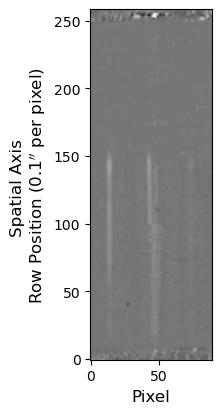

In [46]:
fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spec_dat[15],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

In [143]:
wave_to_fit.shape

(90,)

In [152]:
hdu1 = fits.PrimaryHDU(spec_smoothed)
hdu1.writeto('h2_spec_to_fit_smoothed.fits', overwrite=True)

In [144]:
hdu1 = fits.PrimaryHDU(spec_dat)
hdu1.writeto('h2_spec_to_fit.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(wave_to_fit)
hdu2.writeto('h2_wave_to_fit.fits', overwrite=True)